In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True

config_code_dict = {
    "a": {"fotomultiplicador": False, "laser power": False, "laser light": False},
    "b": {"fotomultiplicador": True, "laser power": False, "laser light": False},
    "c": {"fotomultiplicador": True, "laser power": True, "laser light": False},
    "d": {"fotomultiplicador": True, "laser power": True, "laser light": True},
}

# Una Señal

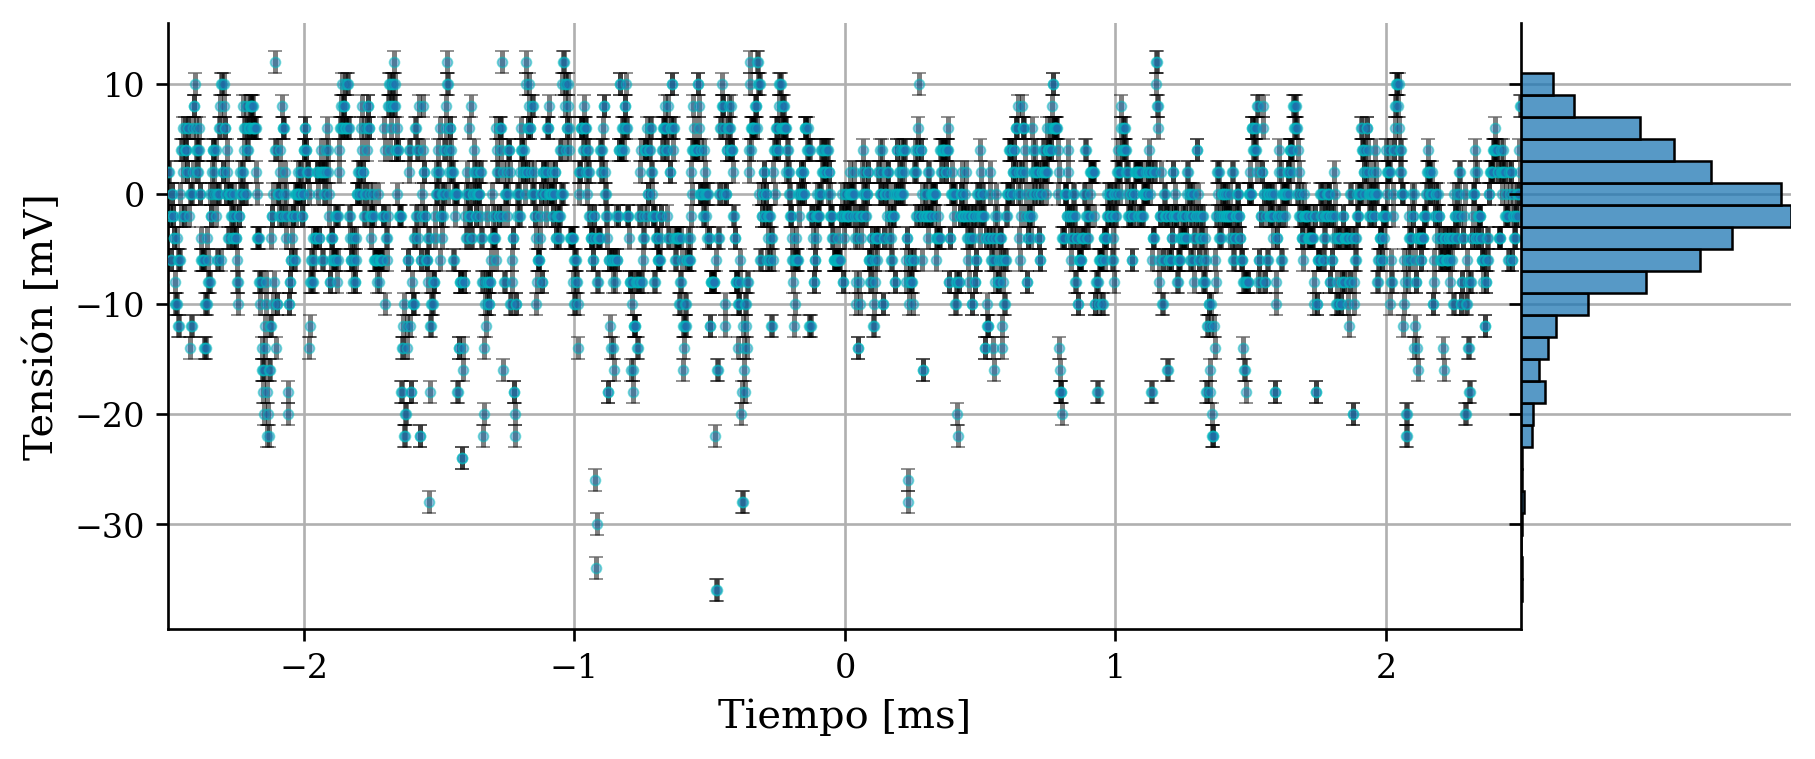

In [3]:
# Leer una tanda guardada:
config = "d"  # Estado del instrumental al medir
tension = 990  # Tensión en la fuente del fotomultiplicador
angulo = 230  # Ángulo relativo entre polarizadores a la salida del láser
modo = "fpeaks"  # Modo del osciloscopio: "fpeaks" para find peaks y "sample" para sampleo
tiempo, channel1 = np.load(f"barrido/{modo}_a{angulo}_t{tension}_{config}.npy")  # s, V
# Ploteando solo una medición a la vez:
med_index = 9
tiempo = tiempo[med_index*2500:(med_index + 1)*2500]
channel1 = channel1[med_index*2500:(med_index + 1)*2500]

res = 2e-3  # V
vals_unicos = np.unique(channel1)
bins = 1e3*np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # mV
g = sns.JointGrid(x=tiempo*1e3, y=channel1*1e3, height=4, ratio=5, space=0)
# g.plot_joint(plt.errorbar, xerr=np.diff(tiempo).mean(),
#              fmt='.', ms=2, mec="k", mew=0.5, alpha=0.5, ecolor='k', capsize=2, zorder=10)
g.plot_joint(plt.errorbar, yerr=1e3*res/2,
             fmt=".", ms=6, mec="c", mew=0.5,
             ecolor="k", capsize=2, alpha=0.5, zorder=10)
g.ax_marg_x.set_visible(False)
g.plot_marginals(sns.histplot, bins=bins, zorder=10)
g.ax_joint.set_xlabel("Tiempo [ms]")
g.ax_joint.set_ylabel("Tensión [mV]")
g.ax_joint.set_xlim(min(tiempo*1e3), max(tiempo*1e3))
g.figure.set_size_inches((8, 3.5))
plt.show()

# Distribución de Tensión

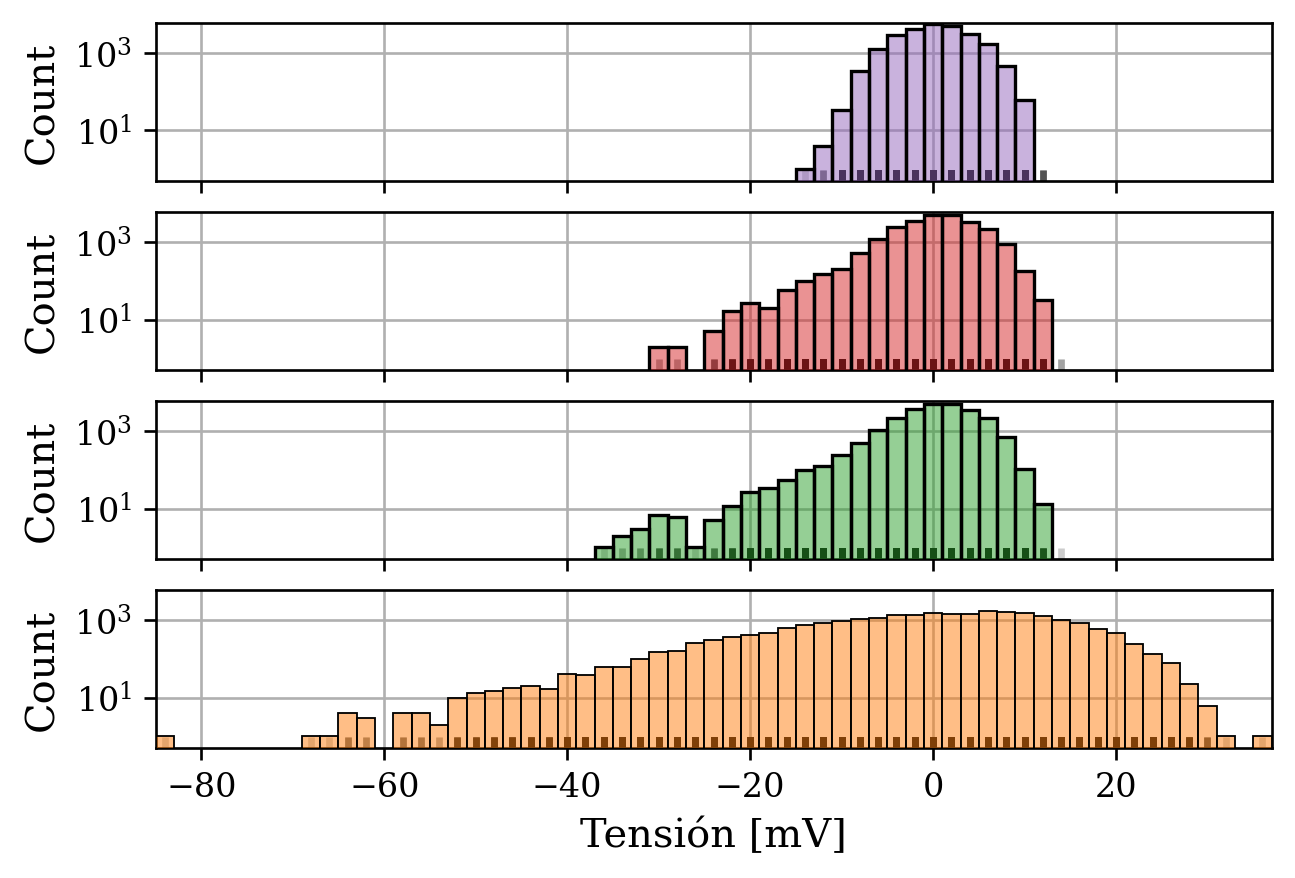

In [28]:
modo = "fpeaks"
angulo = 230
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
color_id = 4
for config, tension, ax in zip(["a", "b", "c", "d"], [0, 990, 990, 990], axs):
    tiempo, channel1 = np.load(f"osci_fpeaks/{modo}_a{angulo}_t{tension}_{config}.npy")  # s, V
    res = 2e-3  # Escala en 50 mV
    # res = 4e-3  # Escala en 100 mV
    vals_unicos = np.unique(channel1)
    bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # V
    sns.histplot(x=channel1*1e3, color=f"C{color_id}", bins=bins*1e3, zorder=10, edgecolor="k",
                    alpha=0.5, label=config + " Sample", ax=ax)
    sns.rugplot(x=channel1*1e3, c="k", height=0.07, alpha=0.2, lw=2, ax=ax)
    color_id -= 1
    ax.set_ylim(5e-1, 6e3)
    ax.set_yscale("log")
# ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")
plt.show()

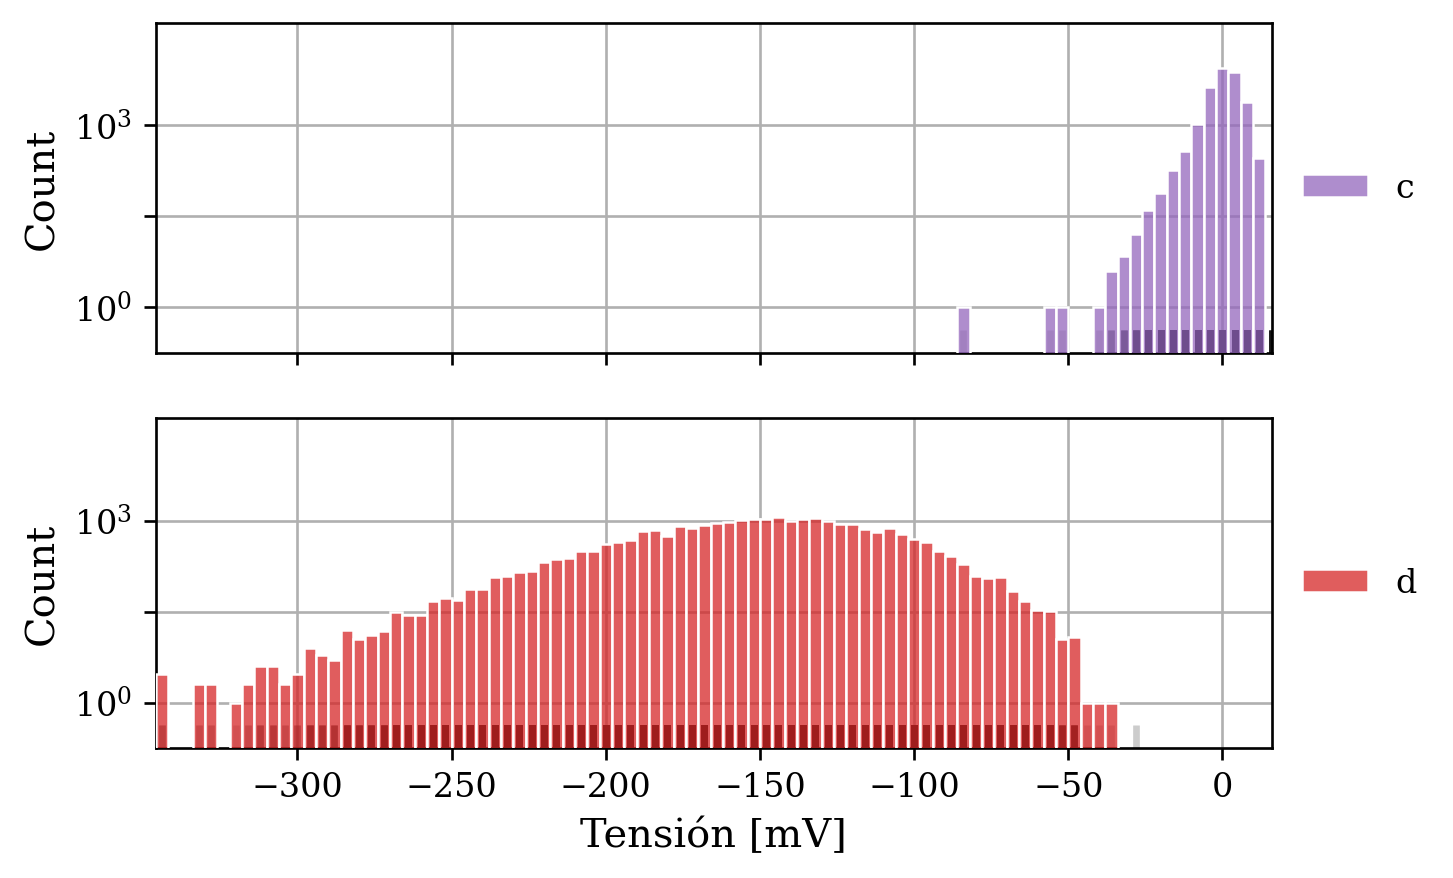

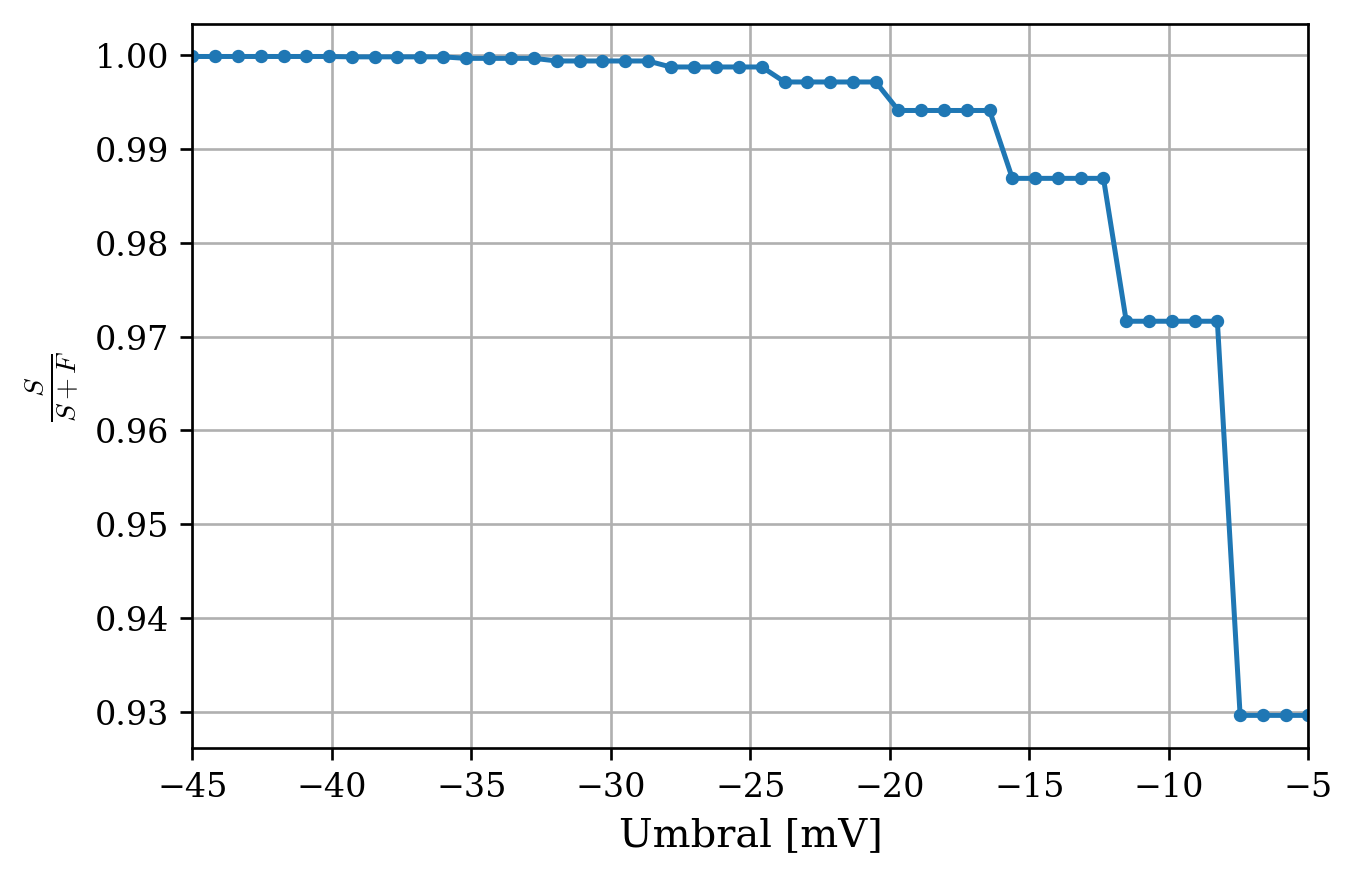

In [33]:
### REVISAR LECTURA DE DATOS: VER ARRIBA PARA EJEMPLOS
fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
tension_dist = dict()
modo = "fpeaks"
tension = 1050  # V
angulo = 230  # °
j = 0
for config, ax in zip(["c", "d"], axs):
    res = 4e-3  # V
    tiempo, channel1 = np.load(f"barrido/{modo}_a{angulo}_t{tension}_{config}.npy")  # s, V
    vals_unicos = np.unique(channel1)
    bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  # V
    sns.histplot(x=channel1*1e3, color=f"C{4-j}", bins=bins*1e3, zorder=10, edgecolor="w",
                 #element="step", fill=False,
                 alpha=0.75, lw=0.75,
                 label=config, ax=ax)
    sns.rugplot(x=channel1*1e3, c="k", height=0.07, alpha=0.2, lw=2, ax=ax)
    tension_dist[config] = channel1
    j += 1
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_yscale("log")
ax.set_yticks([1e0, 10**1.5, 1e3])
ax.set_xlabel("Tensión [mV]")
plt.show()

umbrales = np.linspace(-45e-3, -5e-3, )
frac = np.zeros_like(umbrales)
for i, umbral in enumerate(umbrales):  # V
    positivos_d = sum(tension_dist["d"] <  umbral)
    positivos_c = sum(tension_dist["c"] <  umbral)
    frac[i] = (positivos_d-positivos_c)/(positivos_d)

plt.plot(umbrales*1e3, frac, '.-')
plt.xlabel("Umbral [mV]")
plt.ylabel(r"$\frac{S}{S+F}$")
plt.show()

# Análisis Picos

### Sample

#### Reviso qué parámetros establezco para buscar los picos para que el análisis sea correcto

Modo c, Tensión 930


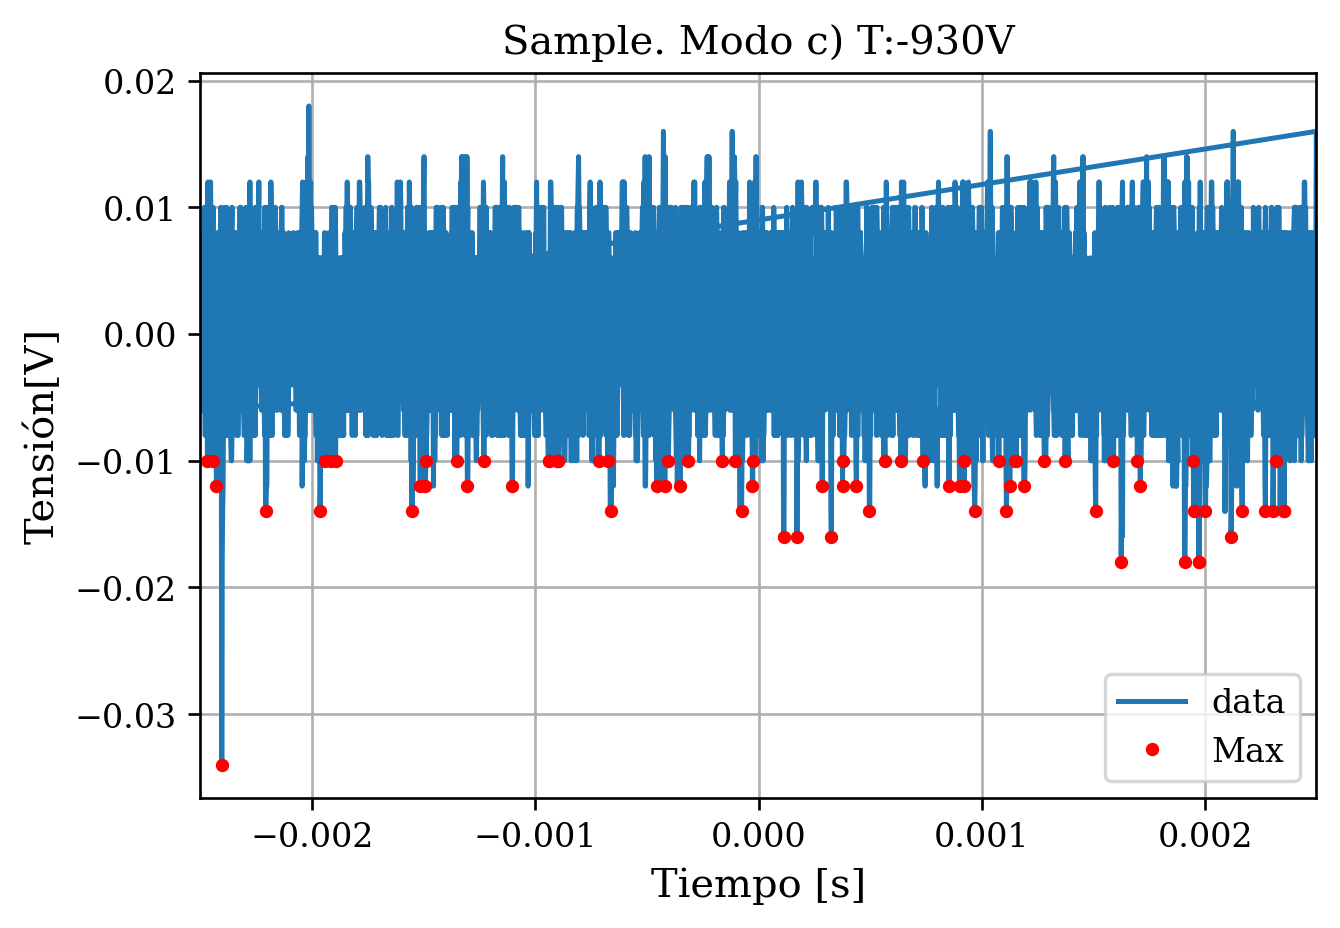

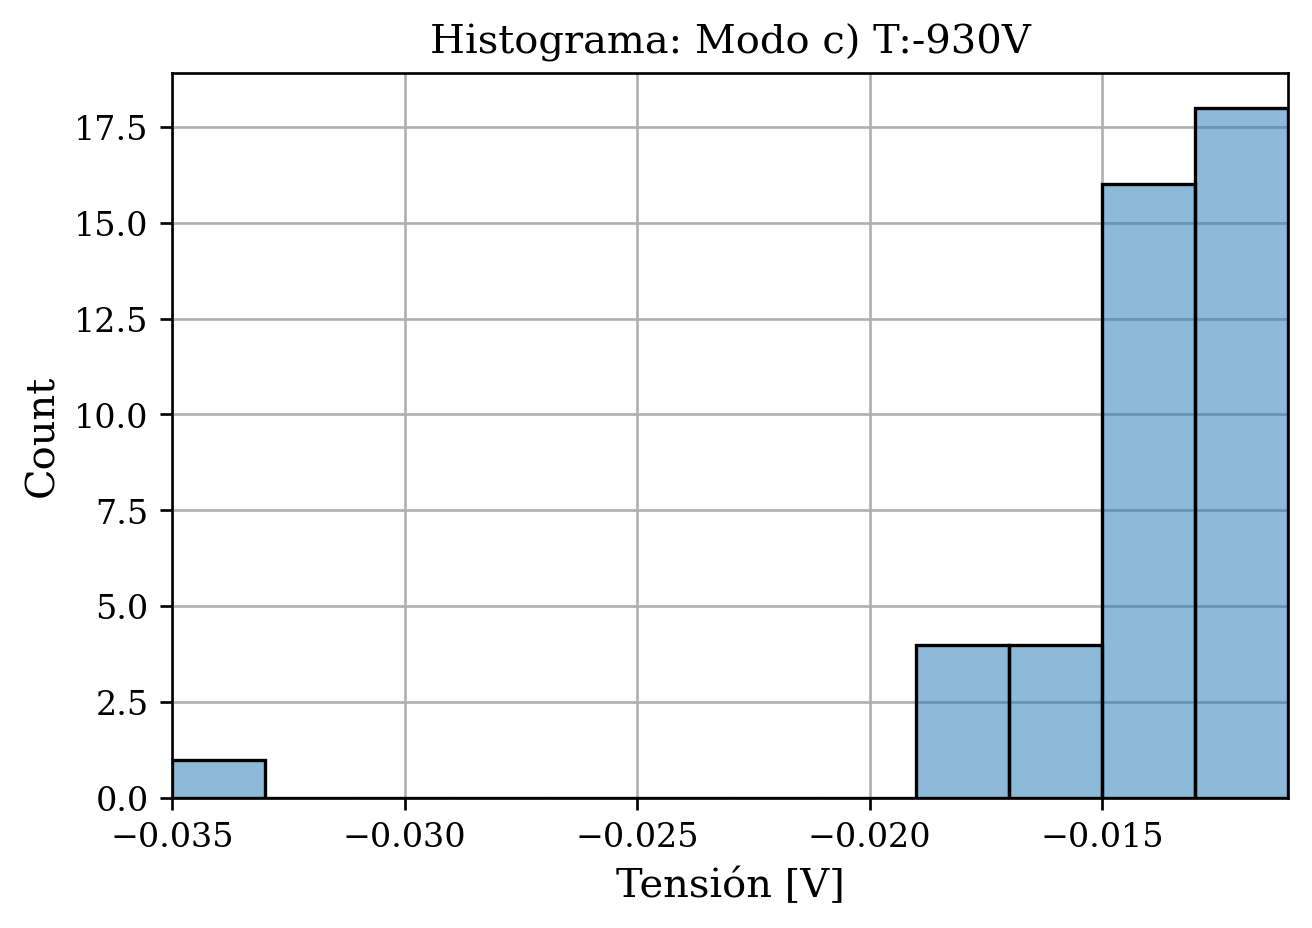

Se encontraron 77 picos.

Modo d, Tensión 930


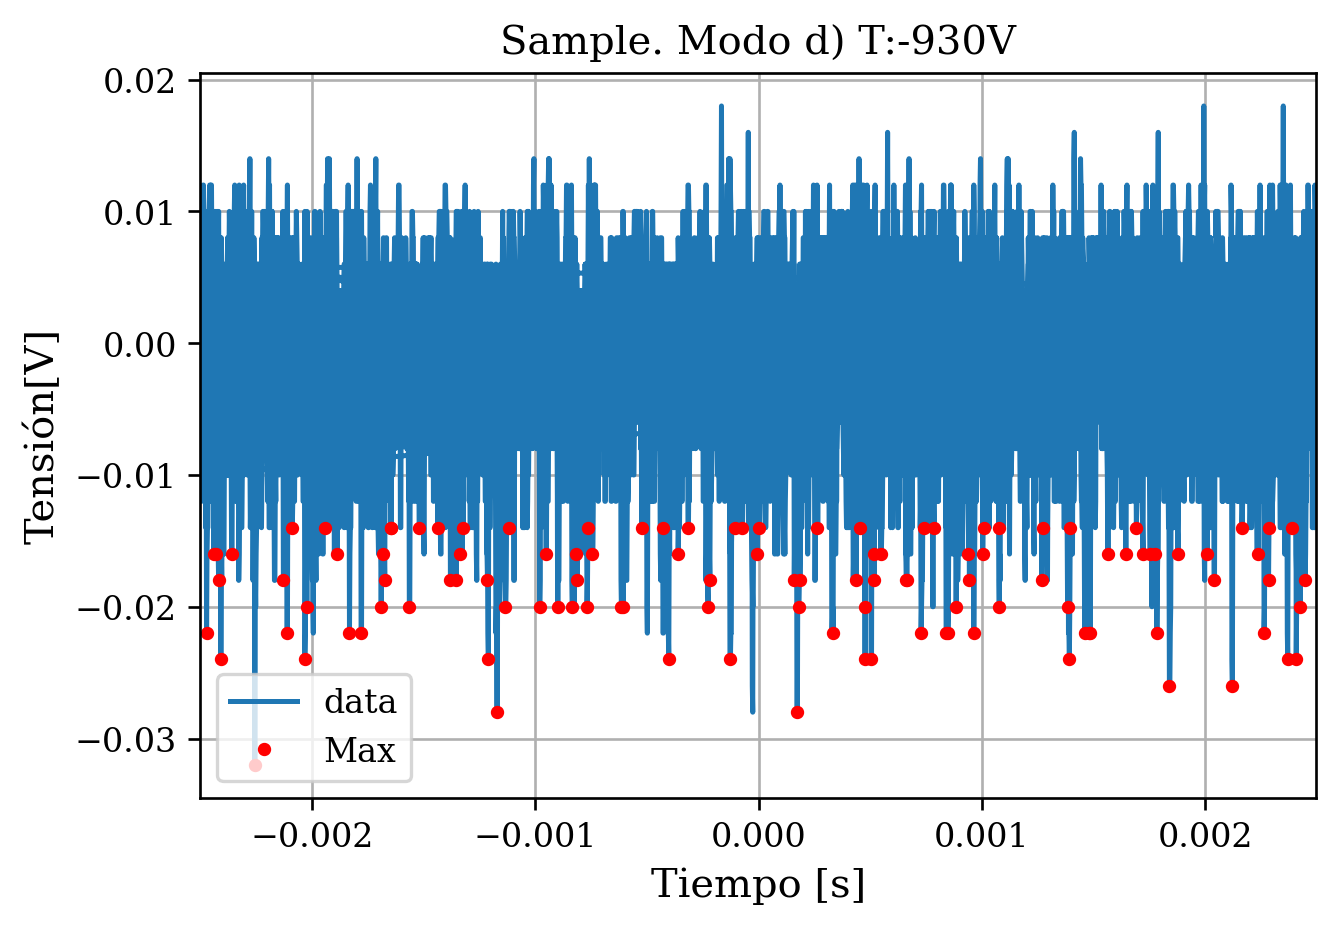

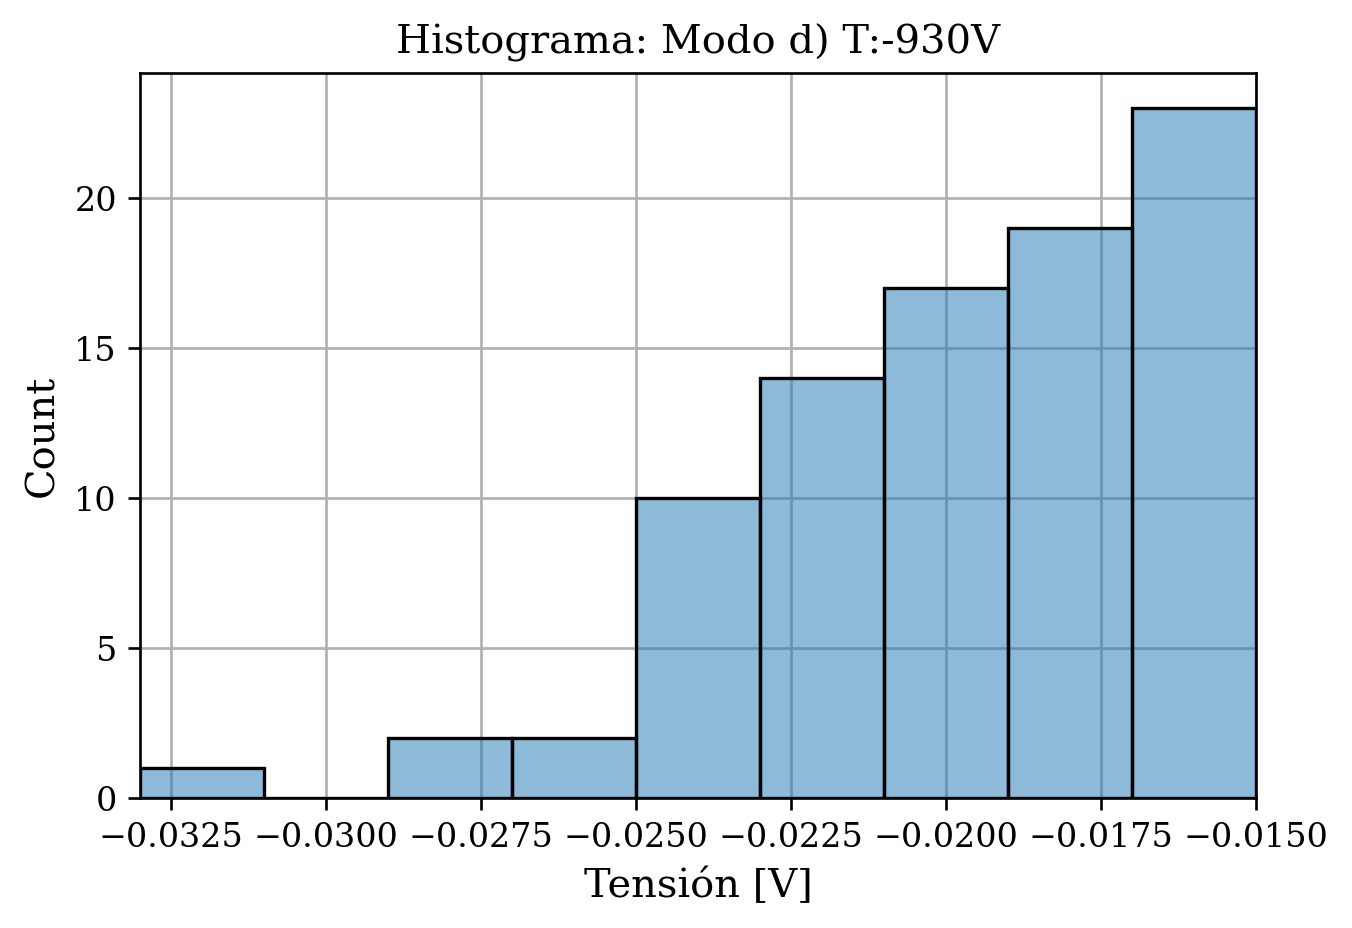

Se encontraron 115 picos.

Modo c, Tensión 990


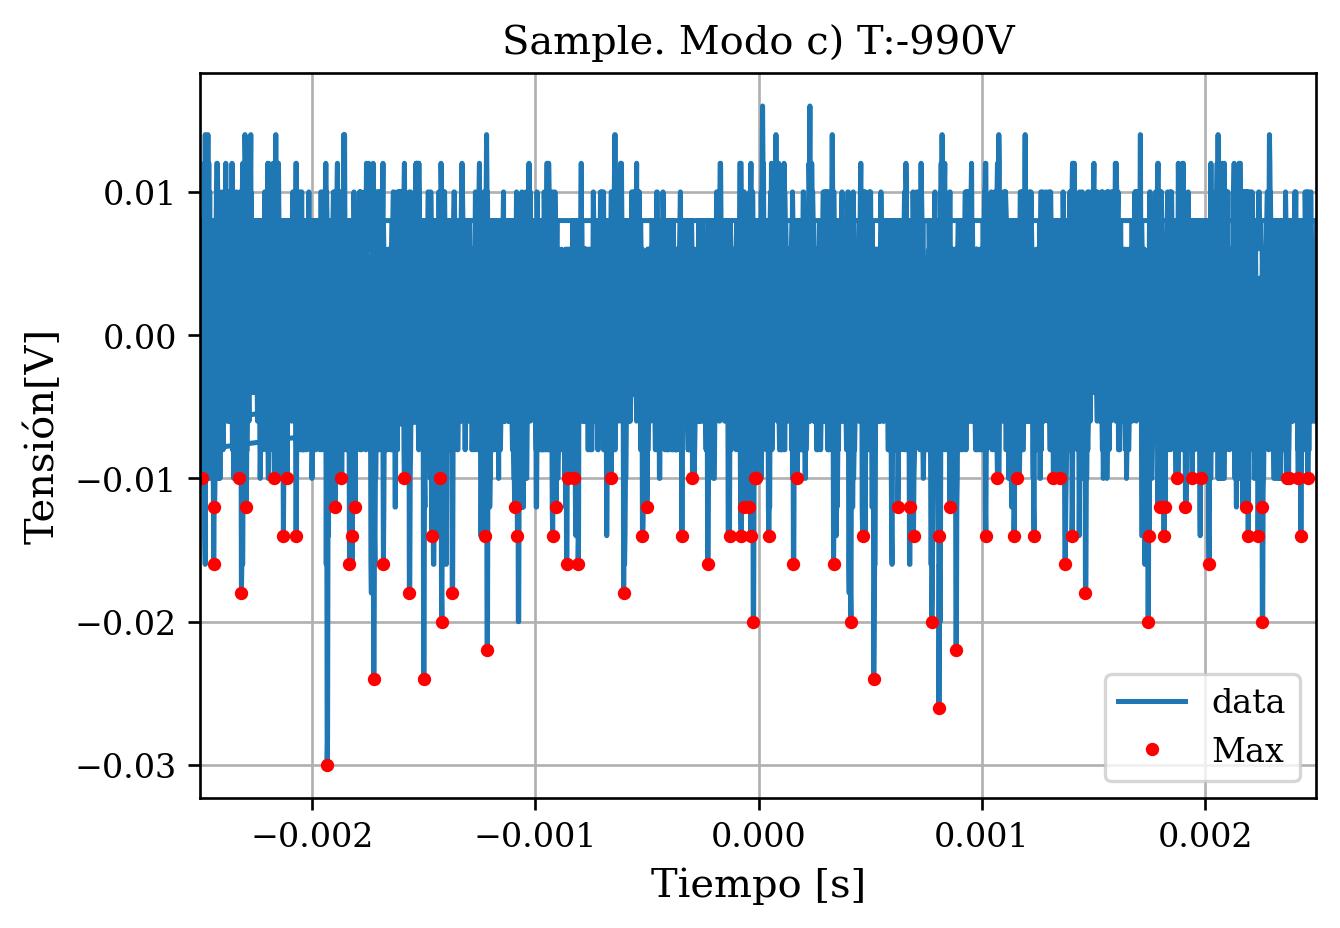

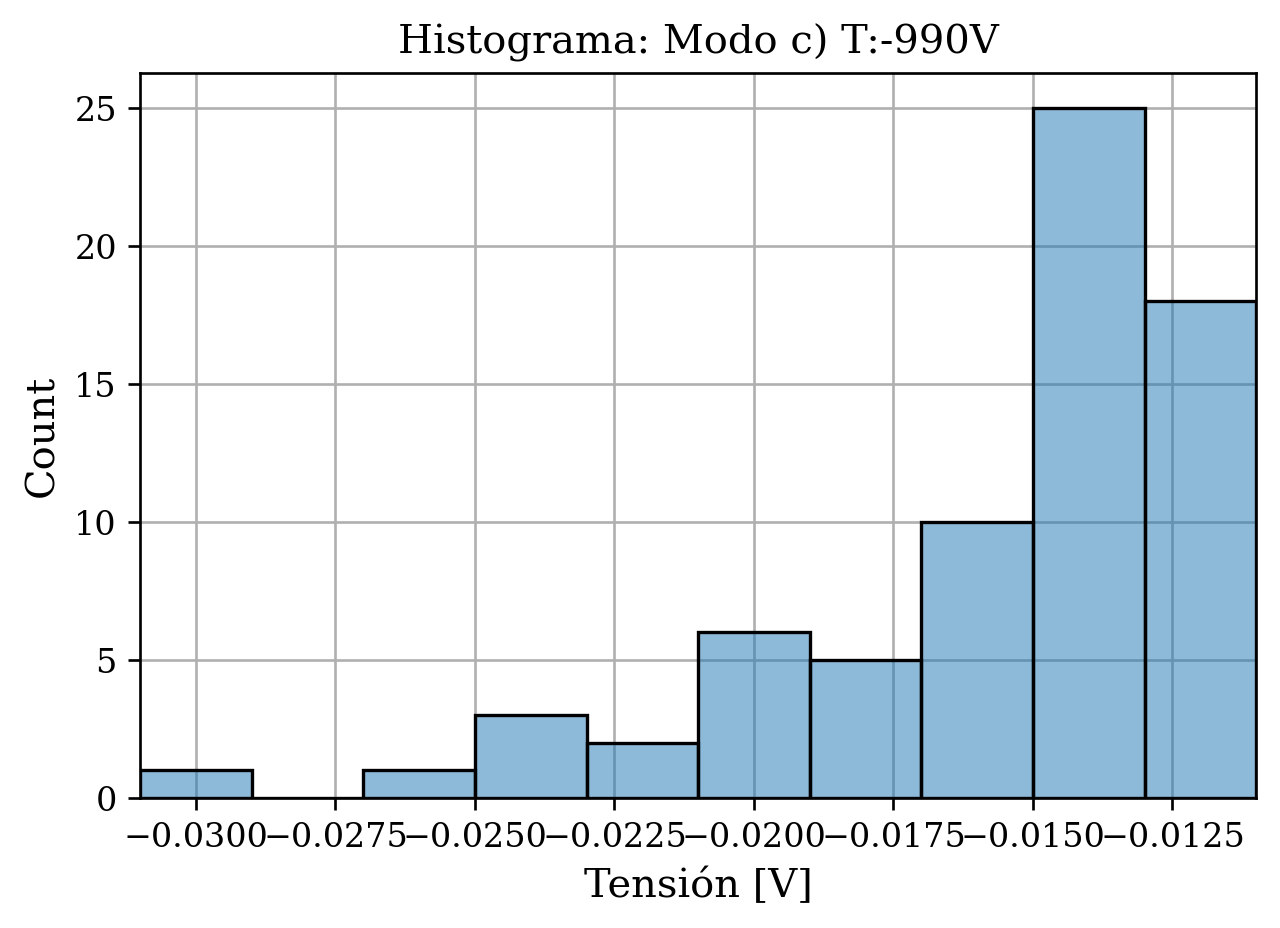

Se encontraron 96 picos.

Modo d, Tensión 990


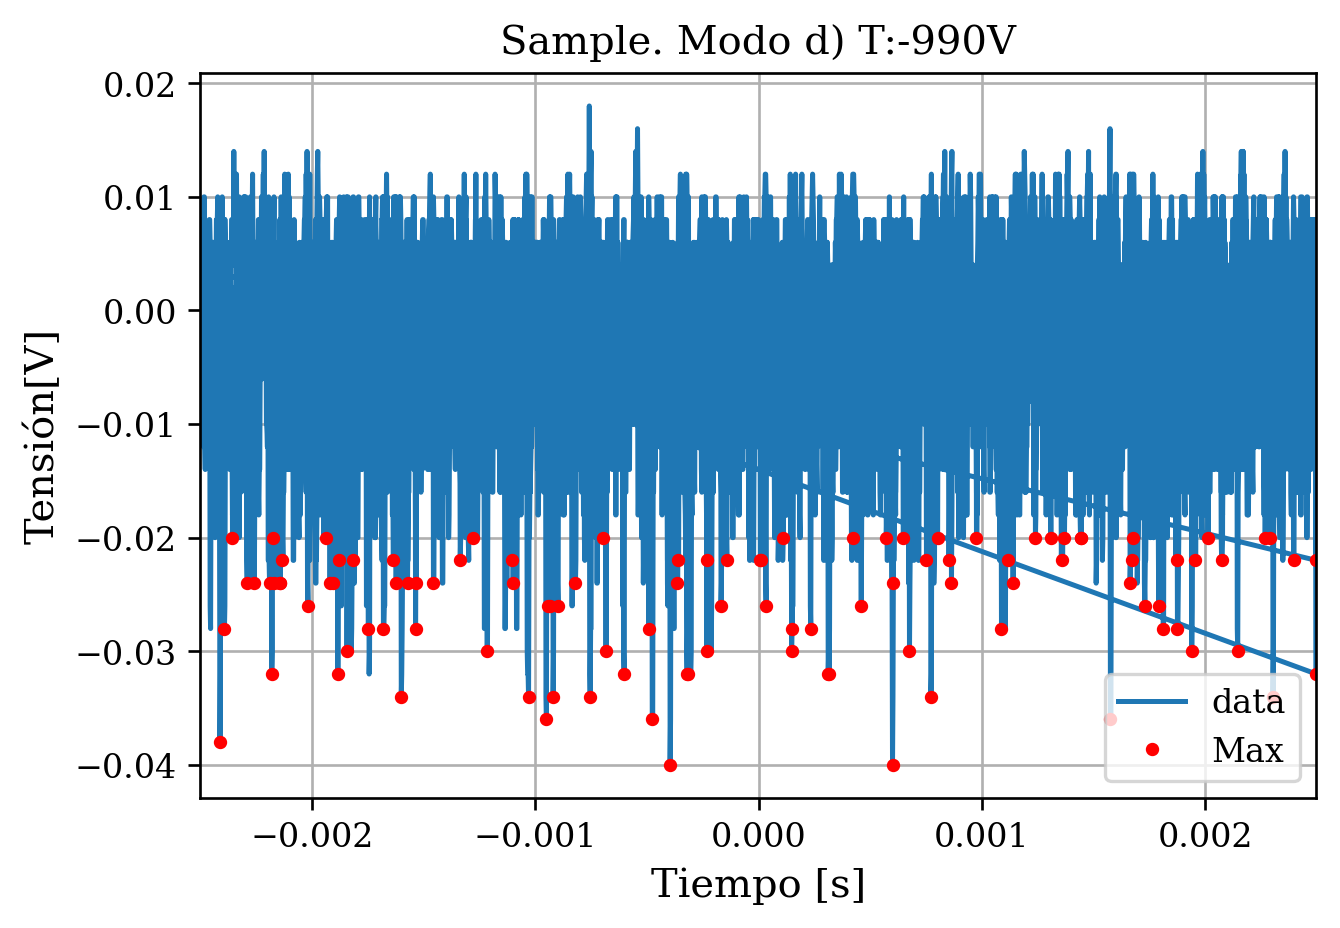

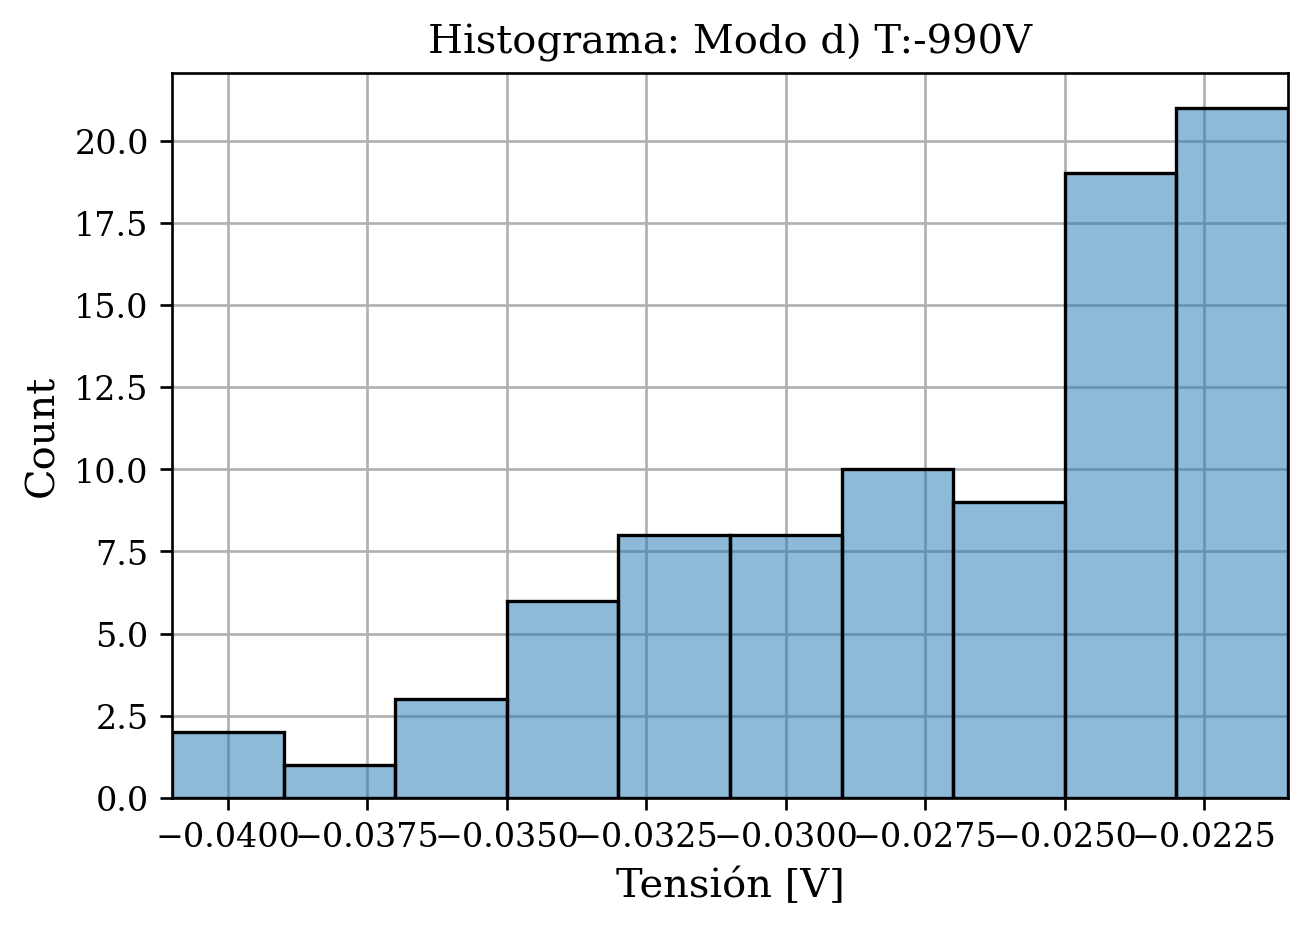

Se encontraron 107 picos.

Modo c, Tensión 1050


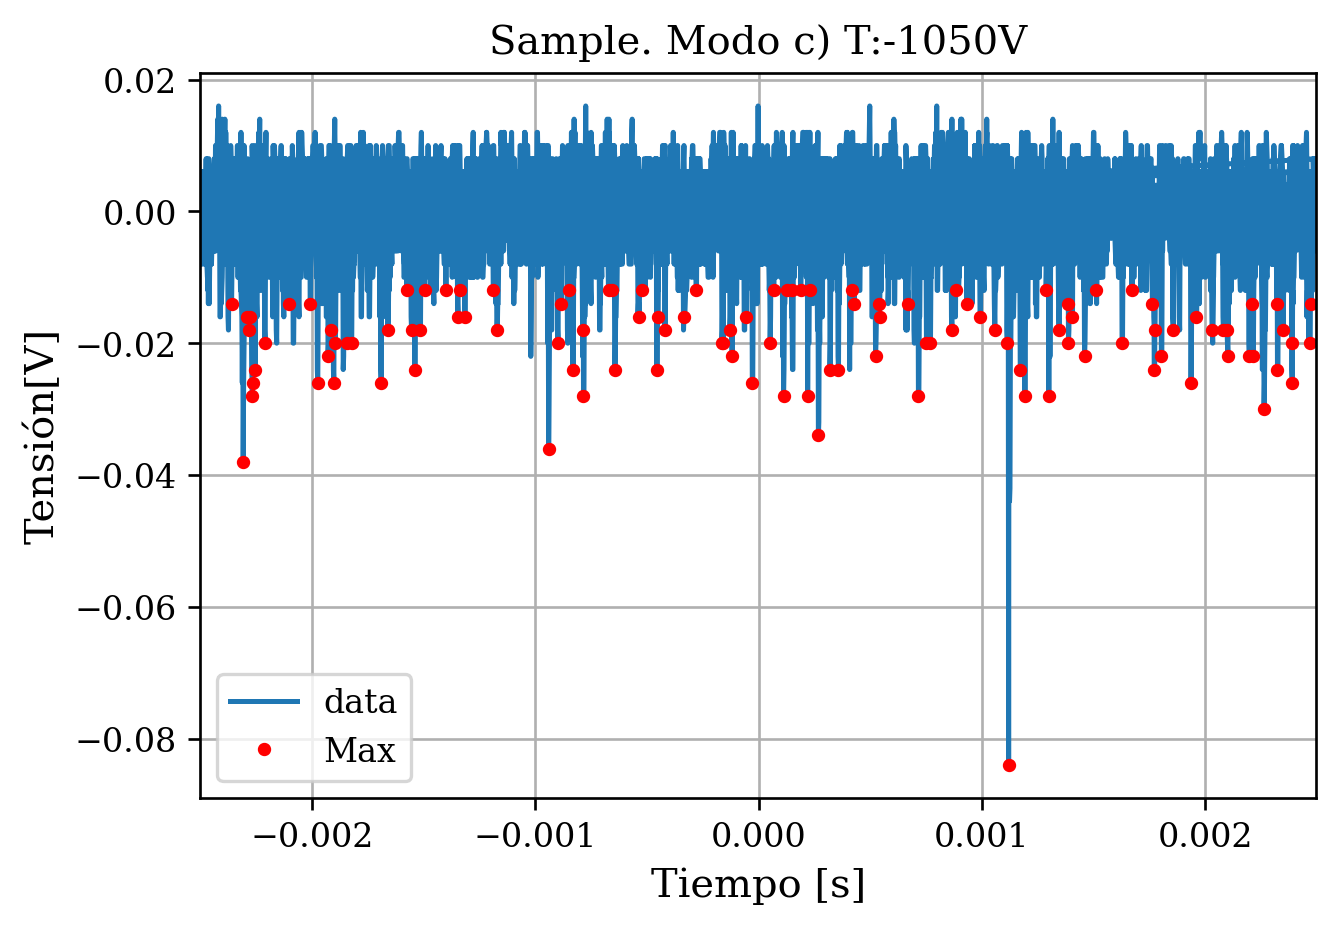

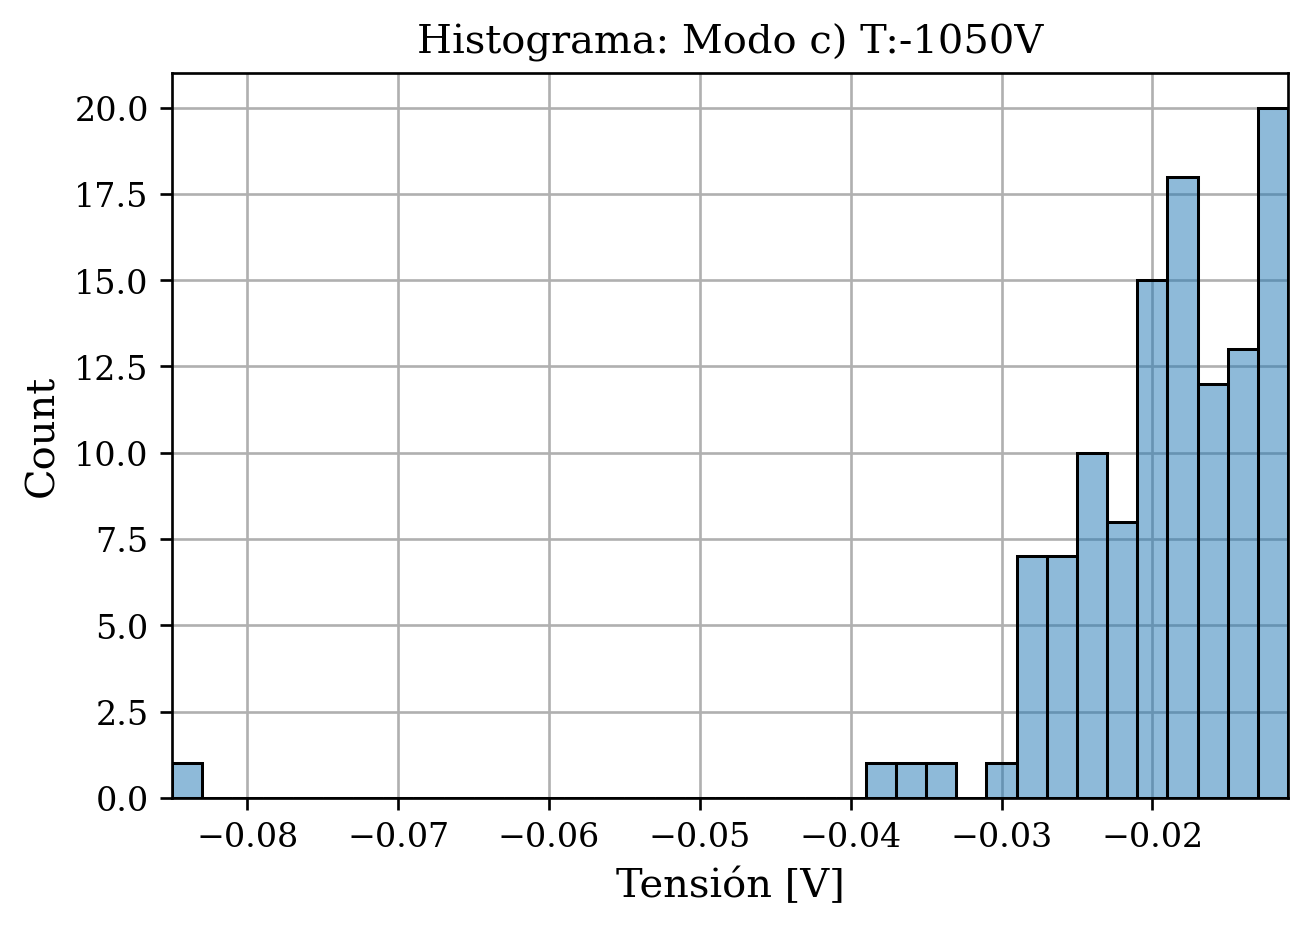

Se encontraron 115 picos.

Modo d, Tensión 1050


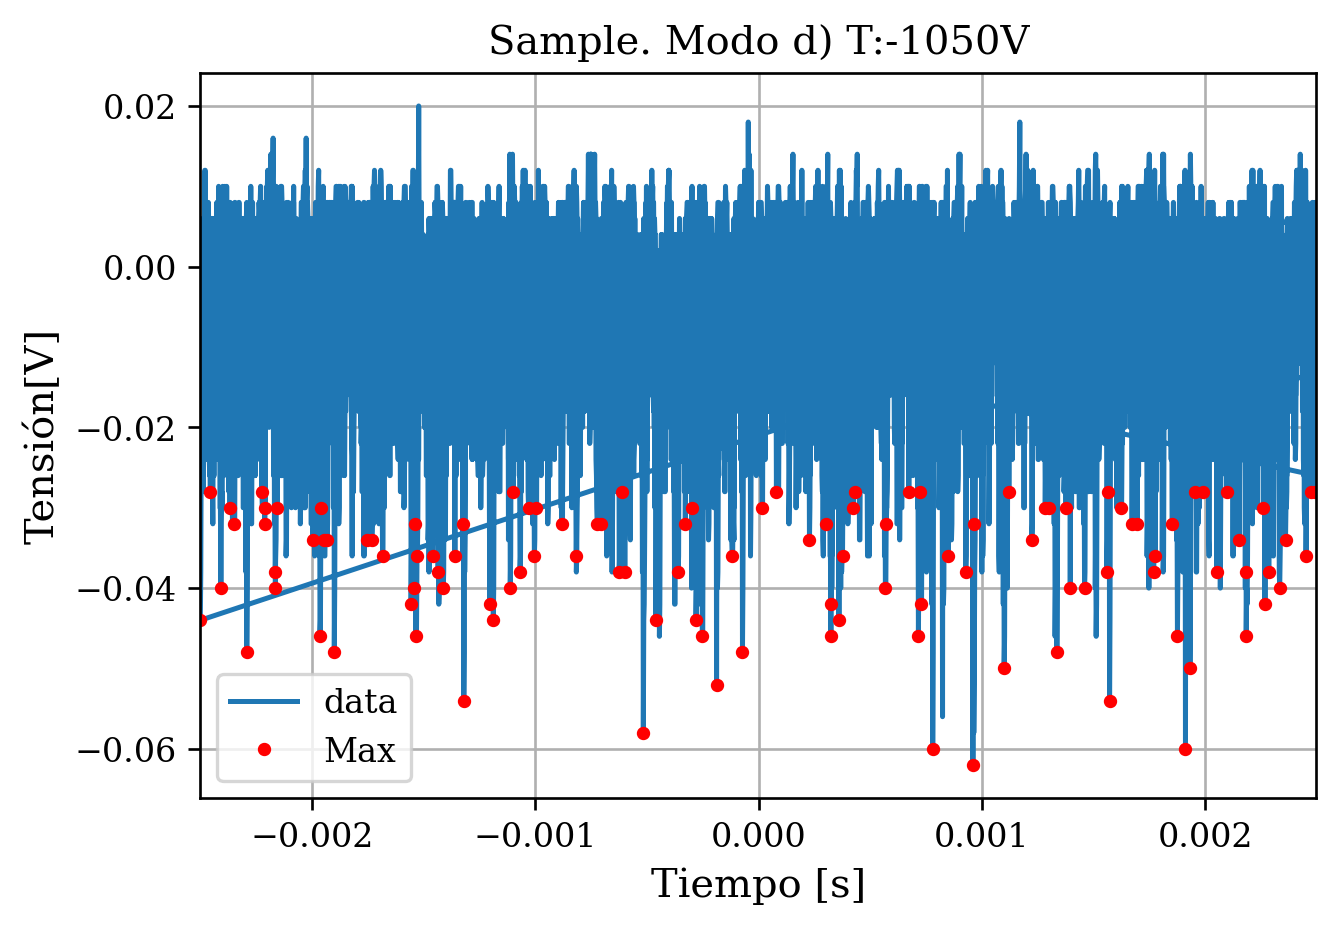

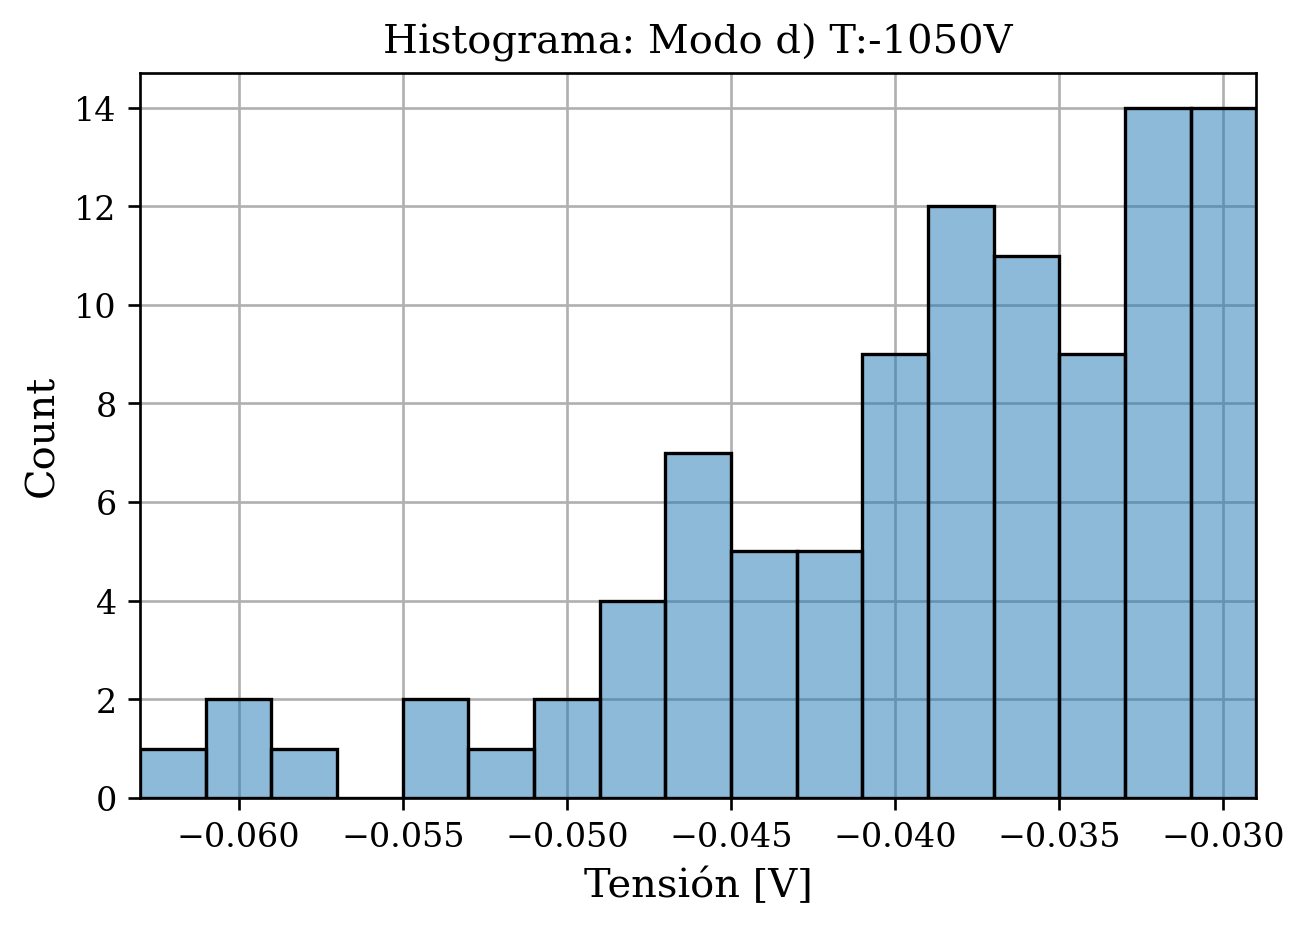

Se encontraron 114 picos.



In [34]:
#Establezco dos criterios para tomar picos

angulo = 230

for tension in ([930, 990, 1050]):
    for config in (["c", "d"]):
        print(f'Modo {config}, Tensión {tension}')
        tiempo, channel1 = np.load(f"barrido/fpeaks_a{angulo}_t{tension}_{config}.npy")  

    #Criterio 1
     #   if (tension>=990) & (config=="d"):
     #       max = find_peaks(-channel1, height=0.025, distance=150)[0] 
     #   elif (tension>=990) & (config=="c"):
     #       max = find_peaks(-channel1, height=0.015, distance=250)[0] 
     #   else:
     #       max = find_peaks(-channel1, height=0.013, distance=150)[0] 

    #Criterio 2: ver que tengan la misma cantidad de puntos contemplados
        height = np.linspace(0.008, 0.030,2000)

        for i in range(len(height)):
            max = find_peaks(-channel1, height=height[i], distance=100)[0]
            if 70<len(max)<120:
                break

        plt.title(f'Sample. Modo {config}) T:-{tension}V')
        plt.plot(tiempo, channel1, label='data')
        plt.plot(tiempo[max], channel1[max], '.', color='red', label='Max')
        plt.ylabel('Tensión[V]')
        plt.xlabel('Tiempo [s]')
        plt.legend()
        plt.show()

        plt.title(f'Histograma: Modo {config}) T:-{tension}V')
        res = 2e-3  
        vals_unicos = np.unique(channel1[max])
        bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  
        sns.histplot(x=channel1[max], bins=bins,zorder=10, edgecolor="k",
                    alpha=0.5, label=config + " Sample")
        plt.xlabel("Tensión [V]")
        plt.show()
        print(f'Se encontraron {len(max)} picos.\n')

#### Grafico la comparación de los Histogramas en modo c y d para distintas tensiones

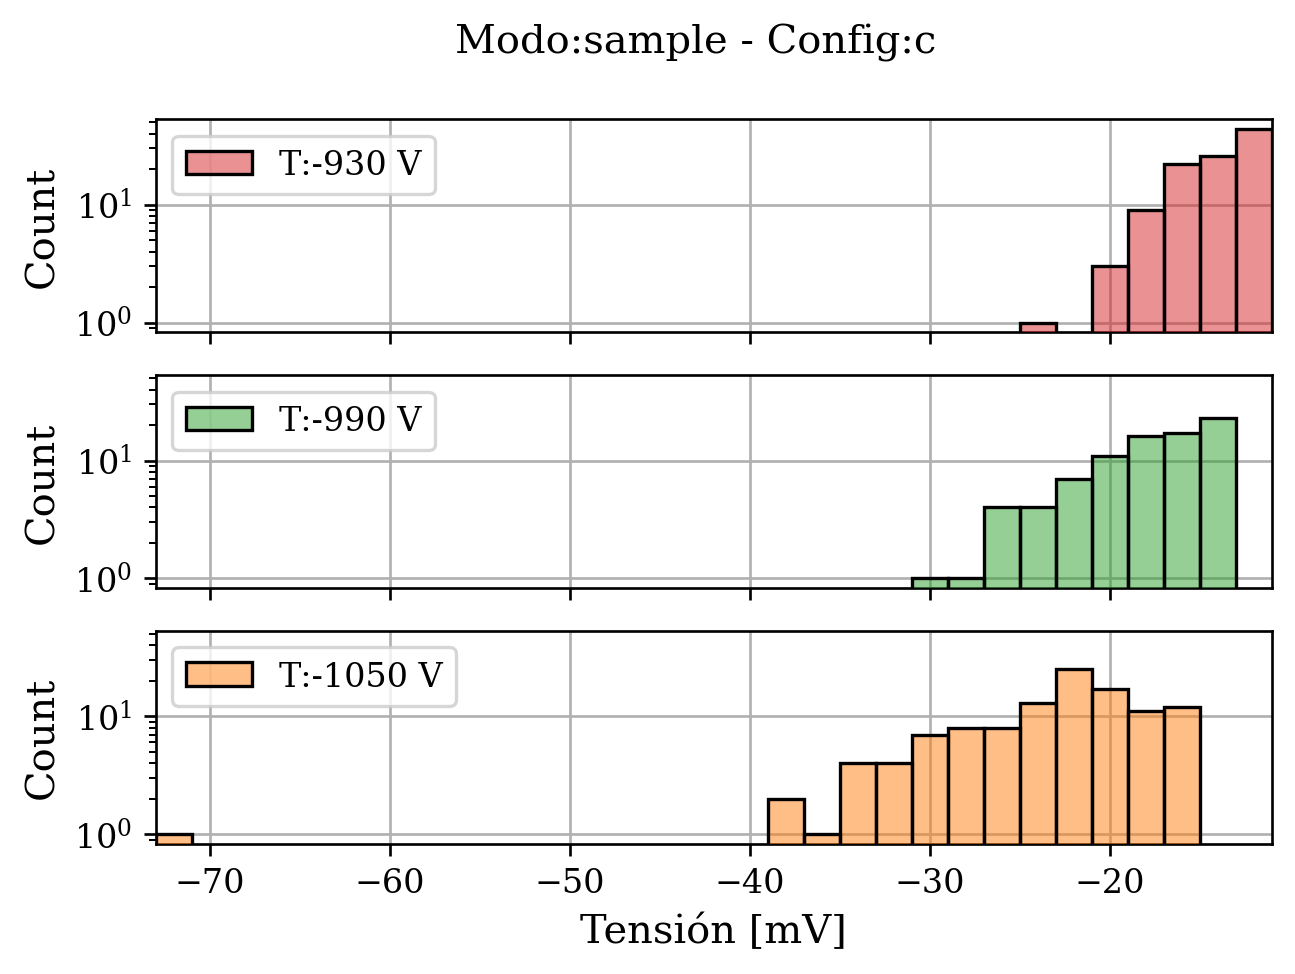

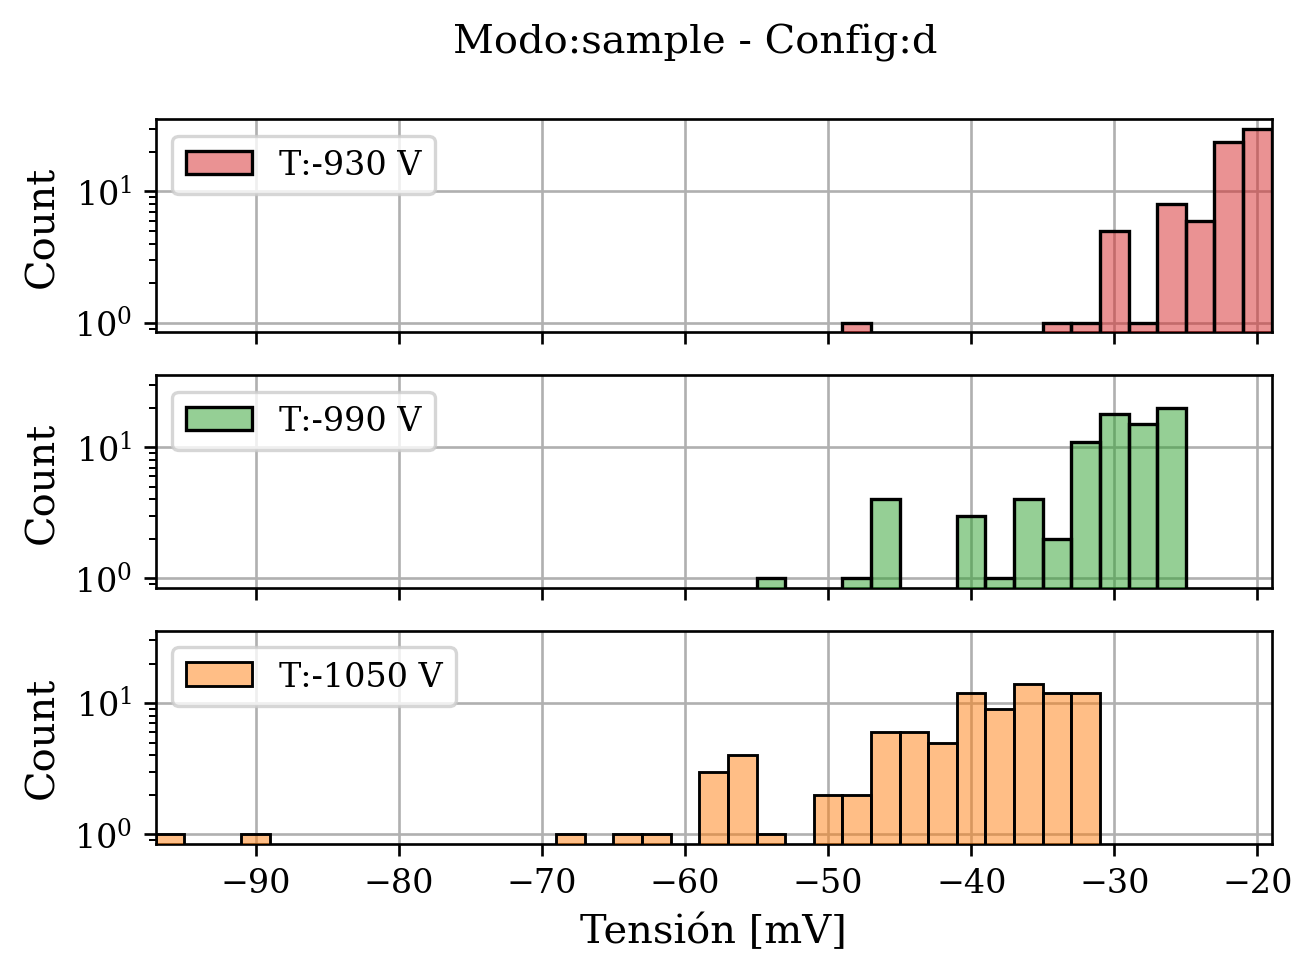

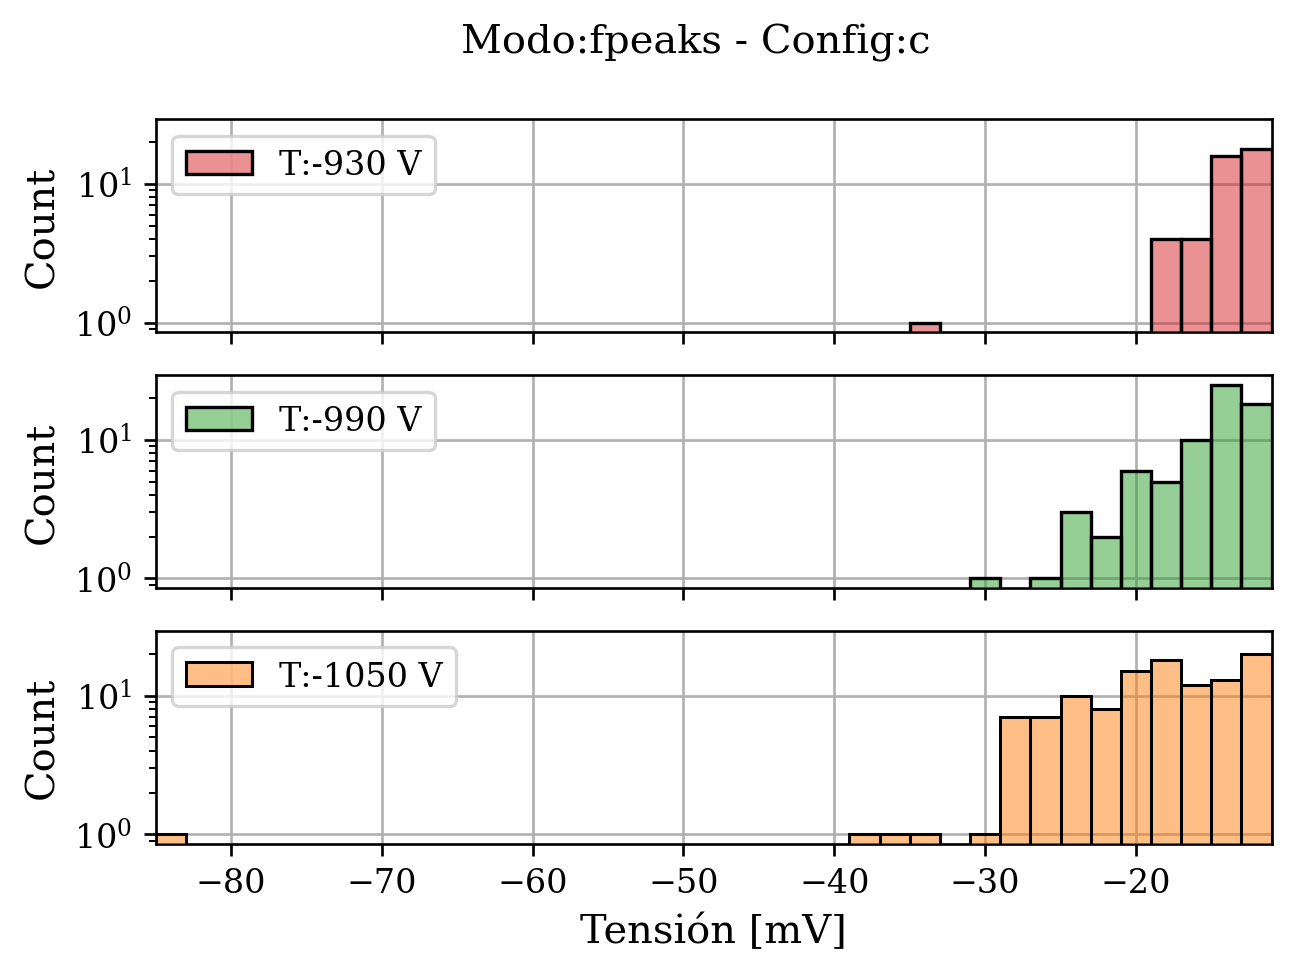

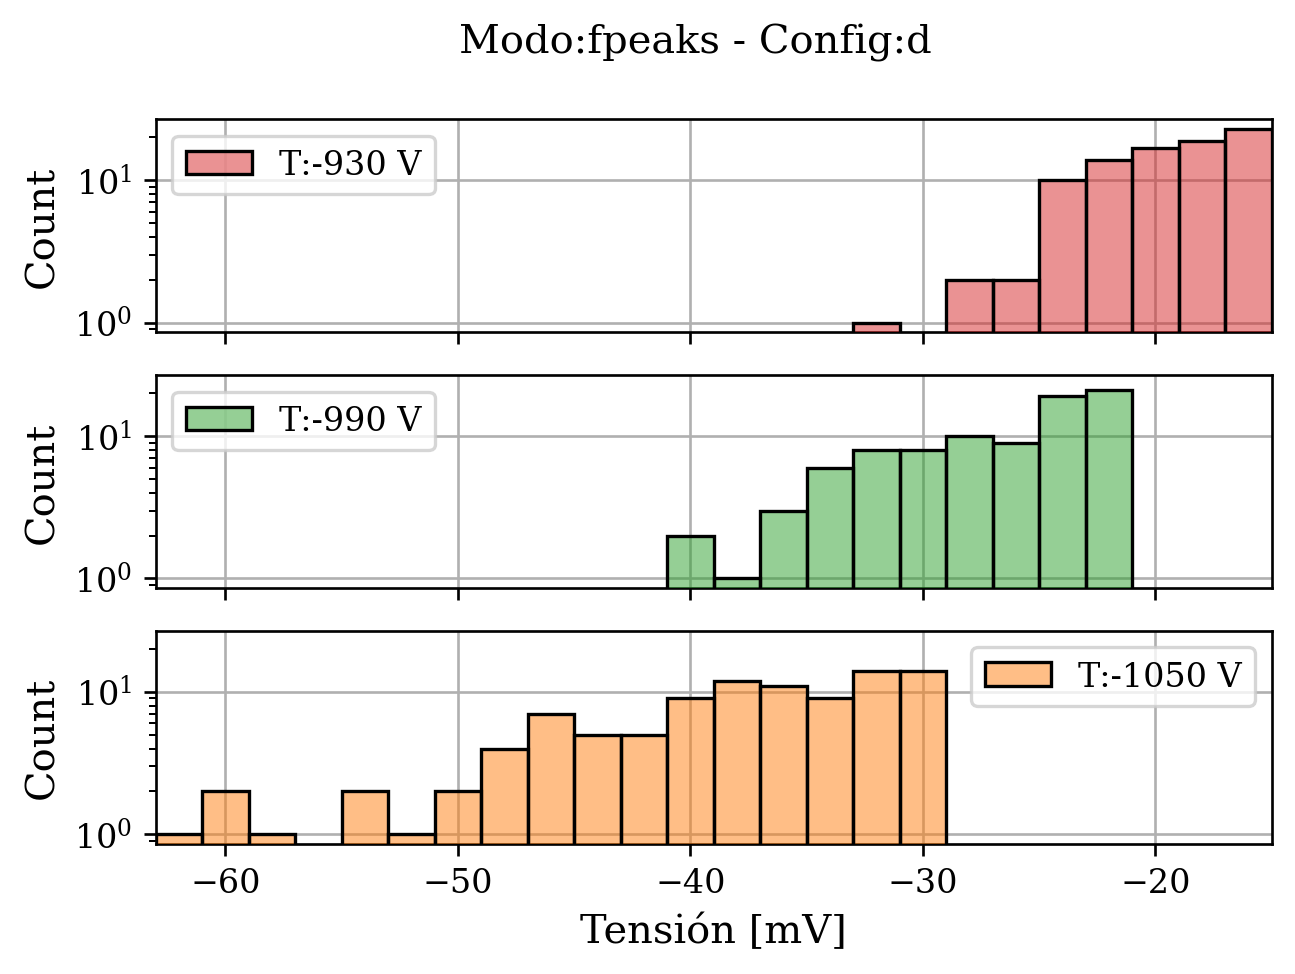

In [35]:
angulo = 230

for modo in (['sample', 'fpeaks']):
    for config in (['c', 'd']):    
        fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)
        fig.suptitle(f'Modo:{modo} - Config:{config}')
        color_id = 3
        for tension, ax in zip([930, 990, 1050], axs):
            tiempo, channel1 = np.load(f"barrido/{modo}_a{angulo}_t{tension}_{config}.npy")  
            res = 2e-3  

            #Criterio 1

            #if (tension>=990) & (config=="d"):
            #    max = find_peaks(-channel1, height=0.025, distance=150)[0] 
            #elif (tension>=990) & (config=="c"):
            #    max = find_peaks(-channel1, height=0.015, distance=250)[0] 
            #else:
            #    max = find_peaks(-channel1, height=0.013, distance=150)[0] 

            #Criterio 2
            if modo == 'fpeaks':
                delta = 0.003
            else:
                delta = 0

            height = np.linspace(0.010 - delta, 0.030,2000)

            for i in range(len(height)):
                max = find_peaks(-channel1, height=height[i], distance=100)[0]
                if 70<len(max)<120:
                    break

            vals_unicos = np.unique(channel1[max])
            bins = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, res)  
            sns.histplot(x=channel1[max]*1e3, color=f"C{color_id}", bins=bins*1e3, zorder=10, edgecolor="k",
                            alpha=0.5,  ax=ax, label = f'T:-{tension} V')
            color_id -= 1
            ax.set_yscale("log")
            ax.legend()
        ax.set_xlabel("Tensión [mV]")
    plt.show()

# Análisis DAQ

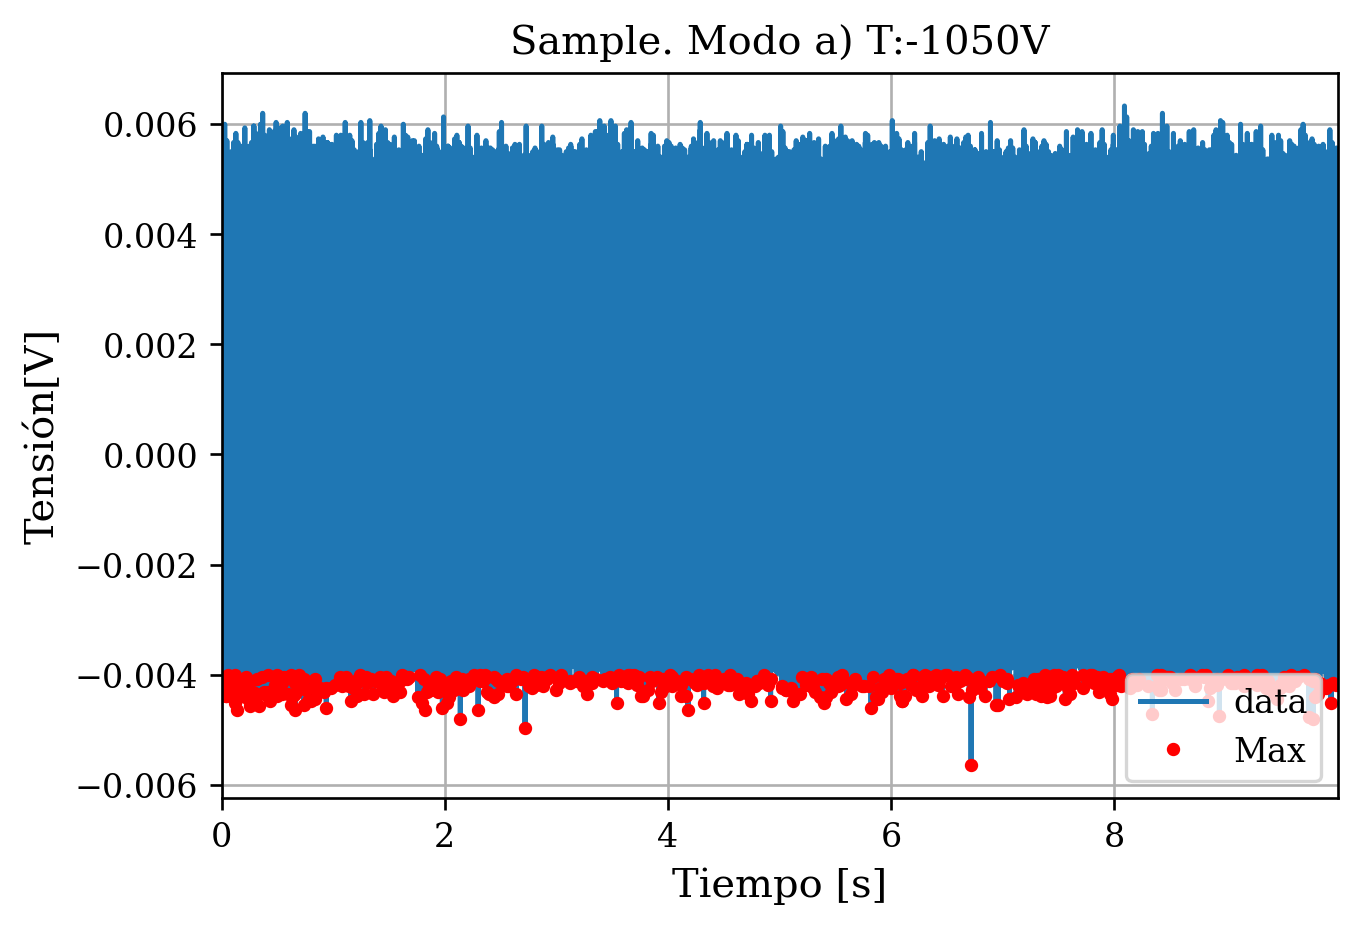

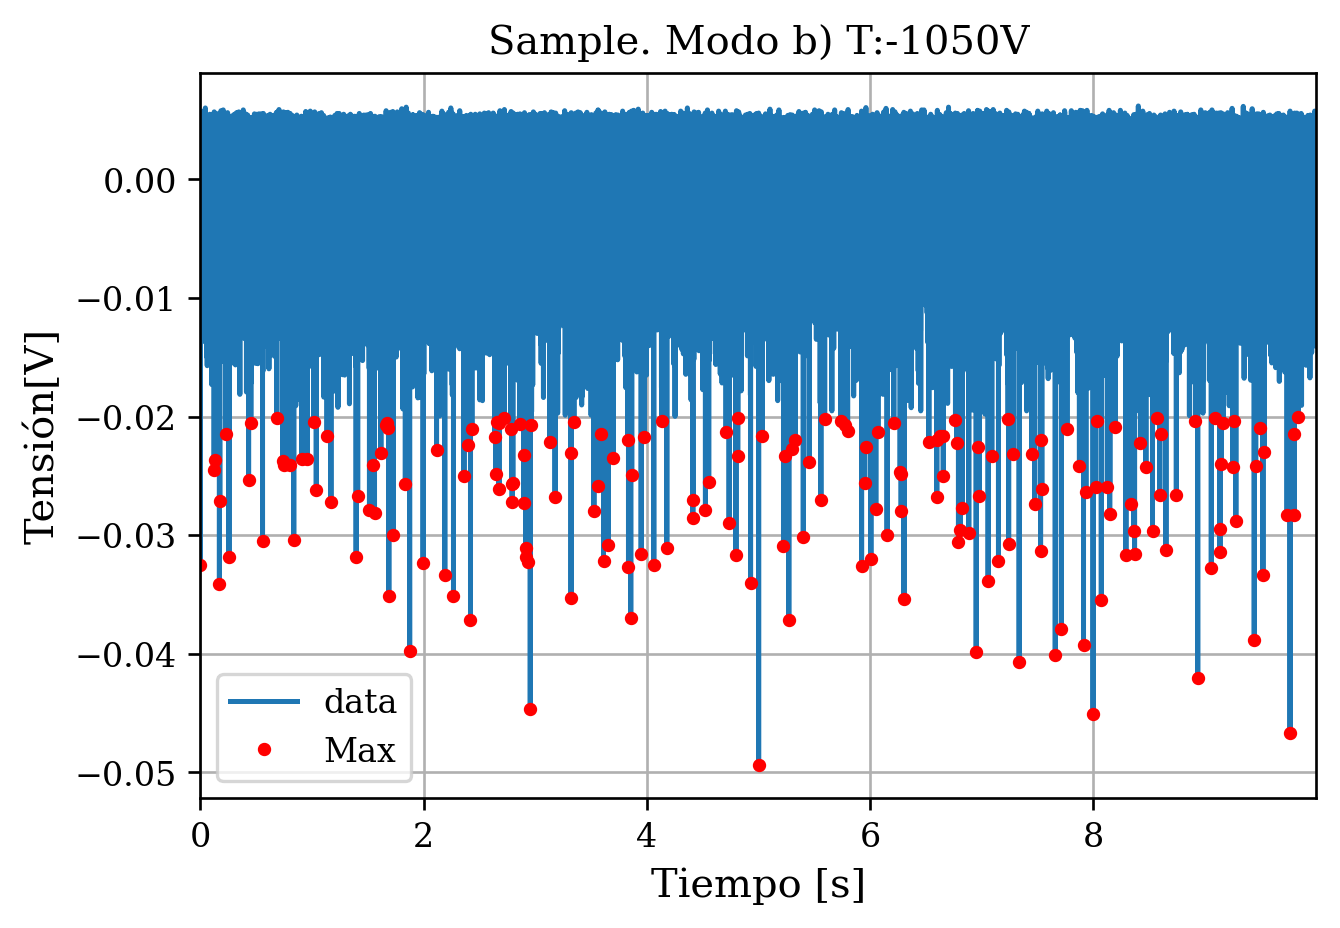

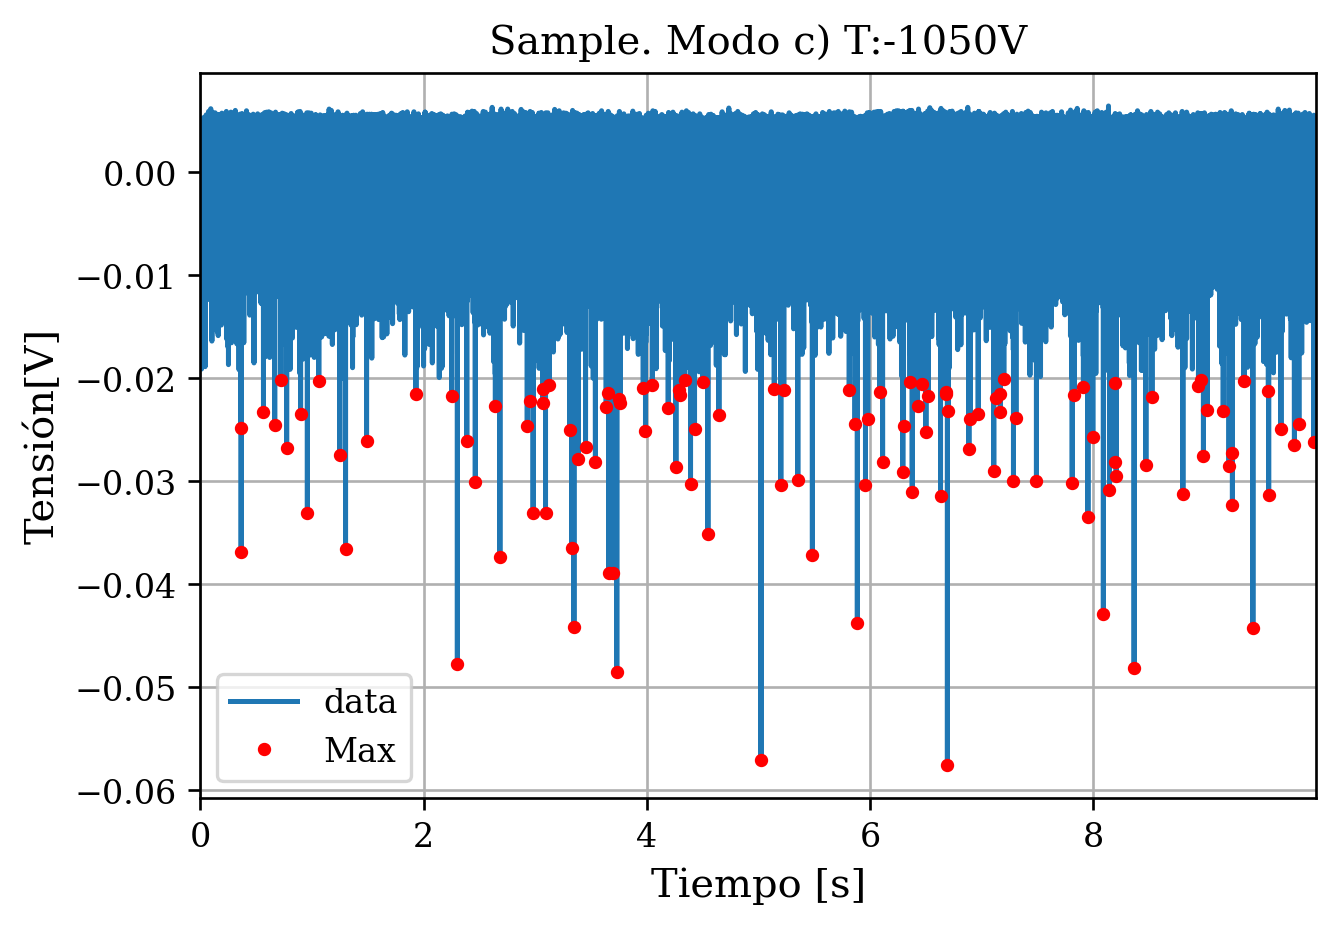

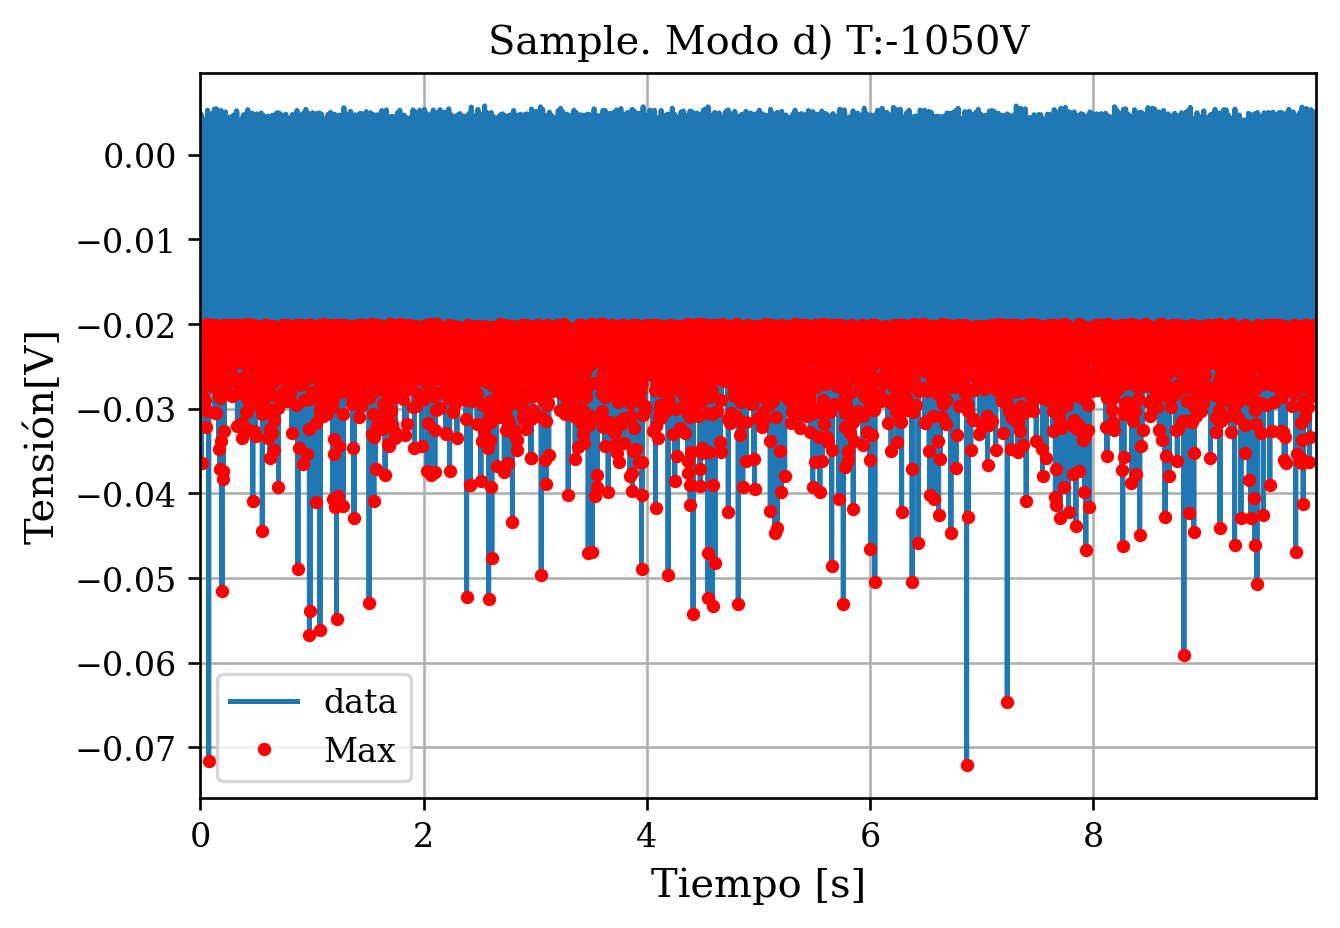

In [33]:
# elijo los picos a mano: esto a optimizar
# grafico para ver que sean medianamente coherentes los parámetros que le paso al find_peaks
# filtrado con condicional sobre las configuraciones
# como despues tengo que hacer (S / S + F) considero que c y d tengan == altura

angulo = 230
tension = 1050  # V
frec_muestreo = 250e3  # Hz
modo = 'sample'
max_val = 300e-3  # V
min_val = -300e-3  # V

for config in (['a','b','c', 'd']):    
    fig.suptitle(f'Modo:{modo} - Config:{config}')
    color_id = 3
    tiempo, channel1 = np.load(f"DAQ_10s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/{modo}_f{frec_muestreo*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  
    res = 1.05*(max_val - (min_val))/(2**16)  # V

    if config == 'a':
        max = find_peaks(-channel1, height = 0.004,distance=100)[0]
    elif config == 'b':
        max = find_peaks(-channel1, height = 0.02,distance=100)[0]
    elif config == 'c':
        max = find_peaks(-channel1, height= 0.02, distance = 100)[0]
    elif config == 'd':
        max = find_peaks(-channel1, height= 0.02, distance = 100)[0]

    plt.title(f'Sample. Modo {config}) T:-{tension}V')
    plt.plot(tiempo, channel1, label='data')
    plt.plot(tiempo[max], channel1[max], '.', color='red', label='Max')
    plt.ylabel('Tensión[V]')
    plt.xlabel('Tiempo [s]')
    plt.legend()
    plt.show()


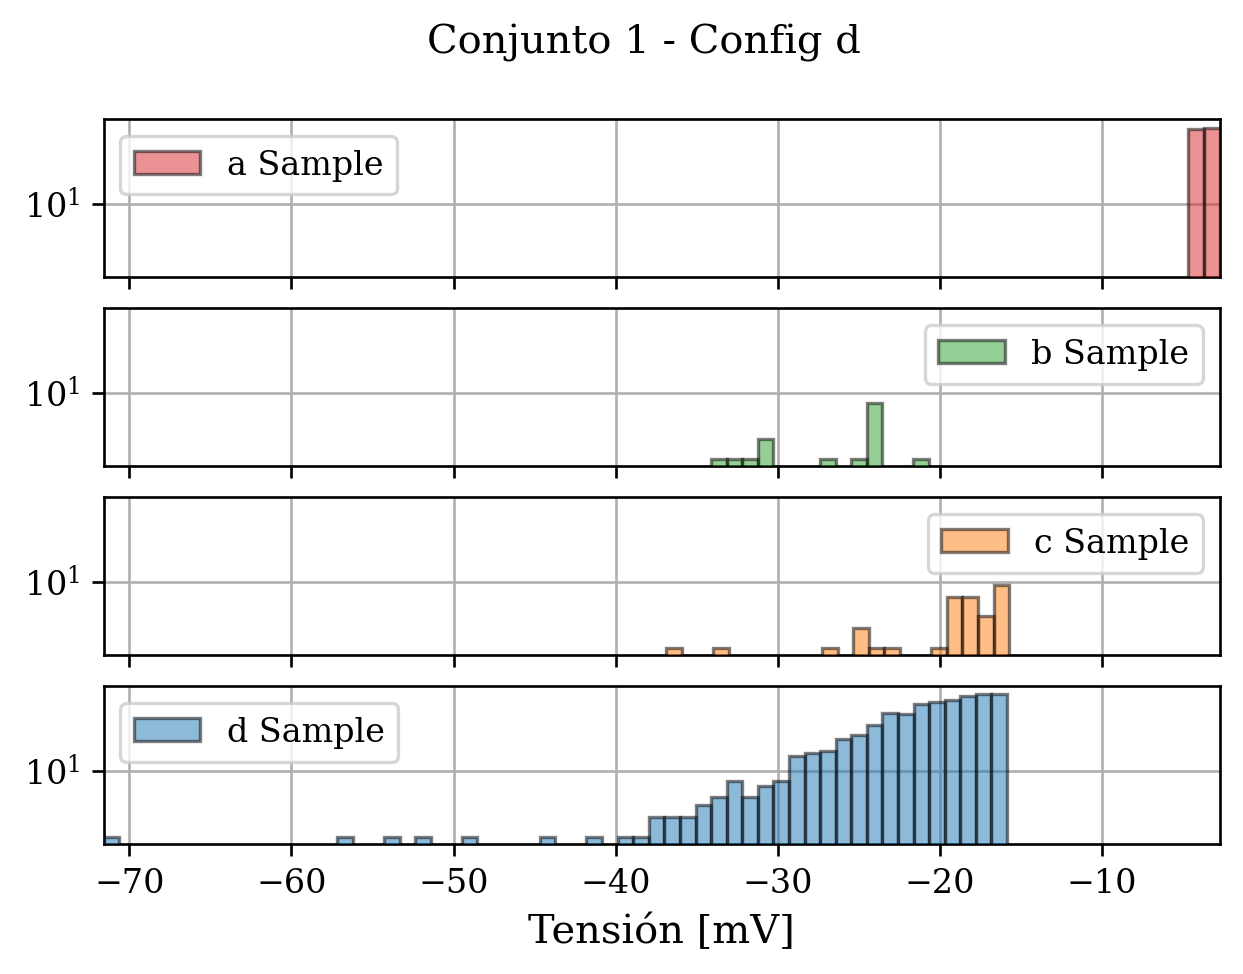

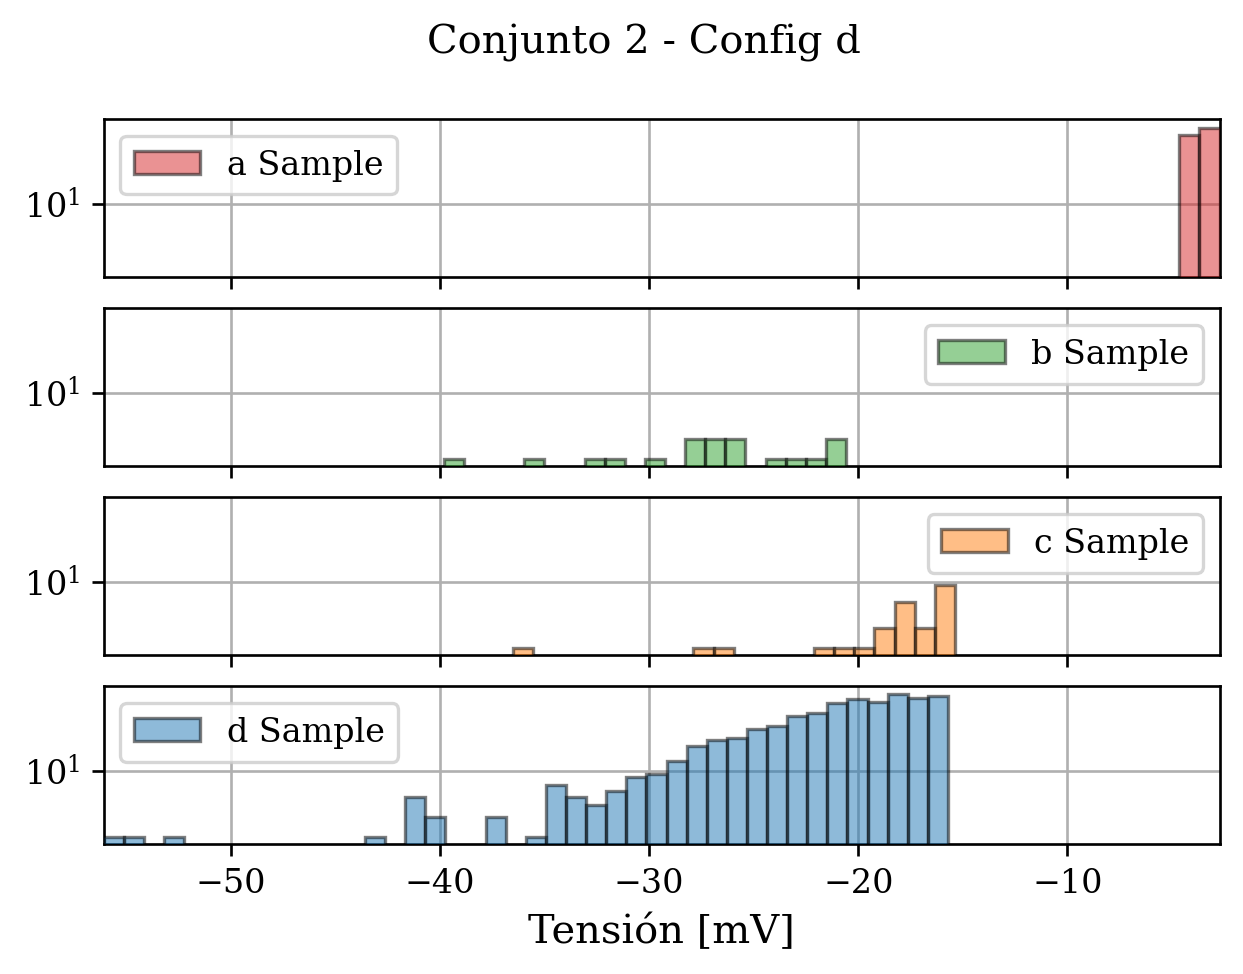

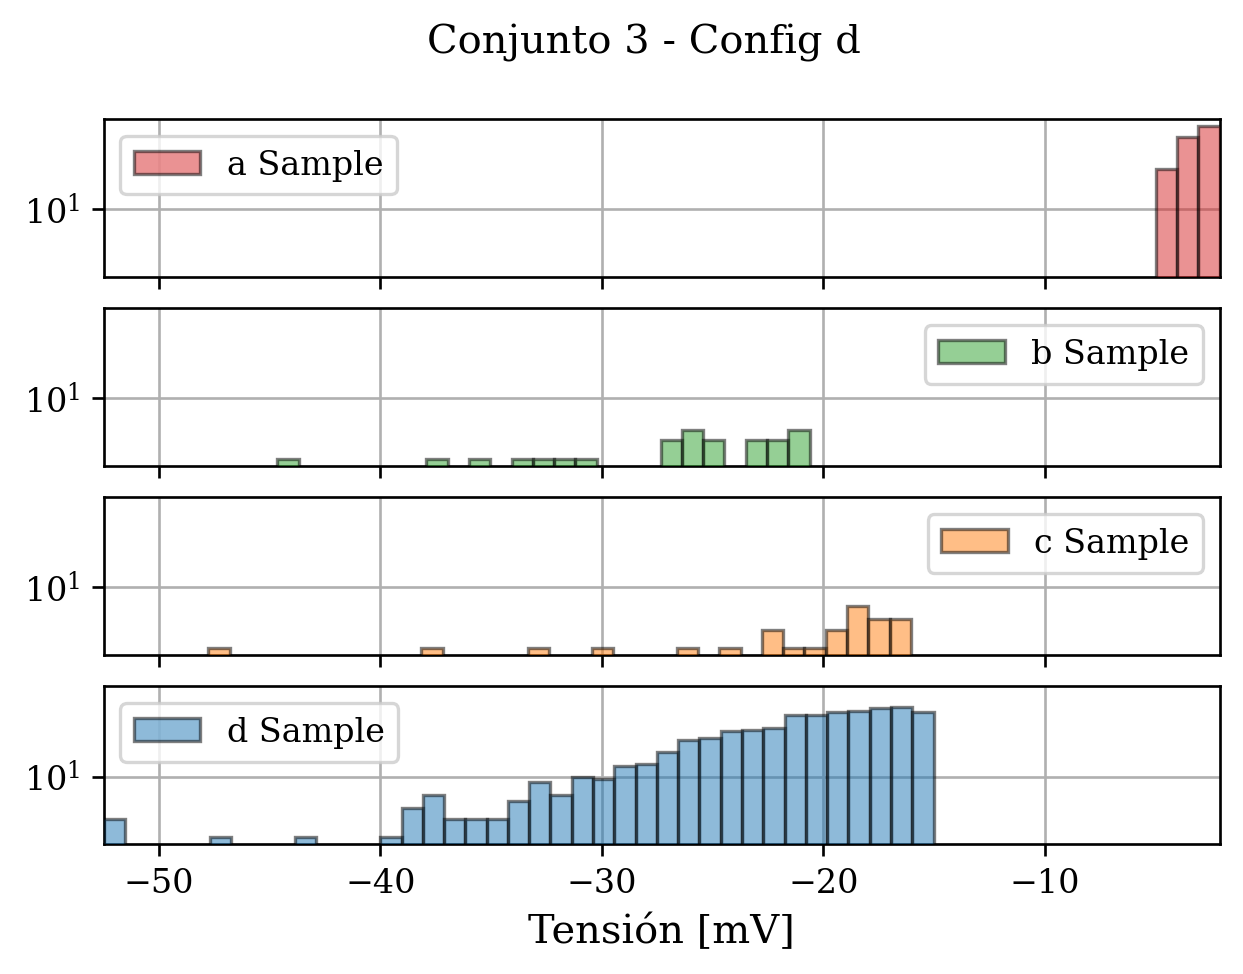

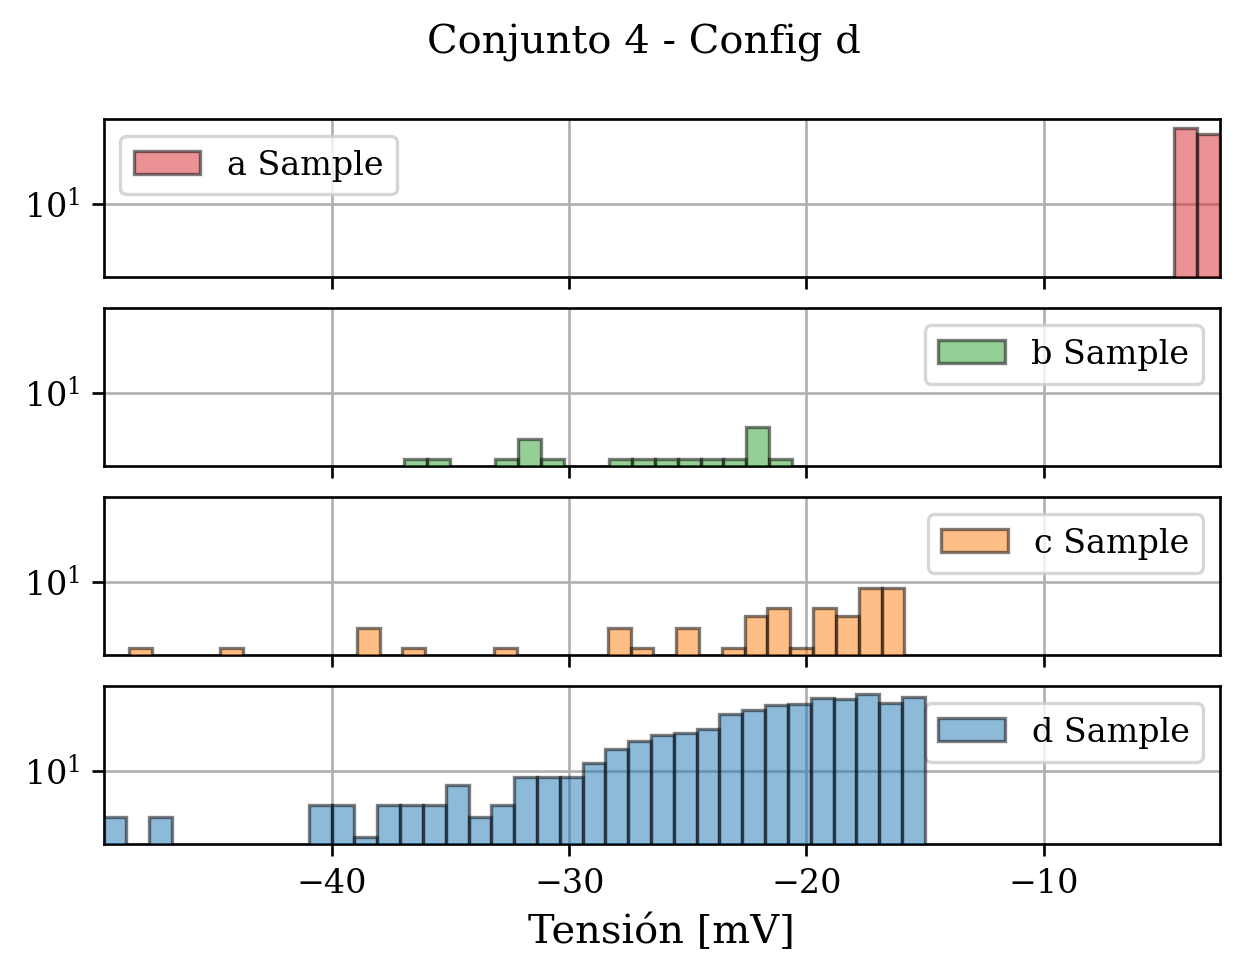

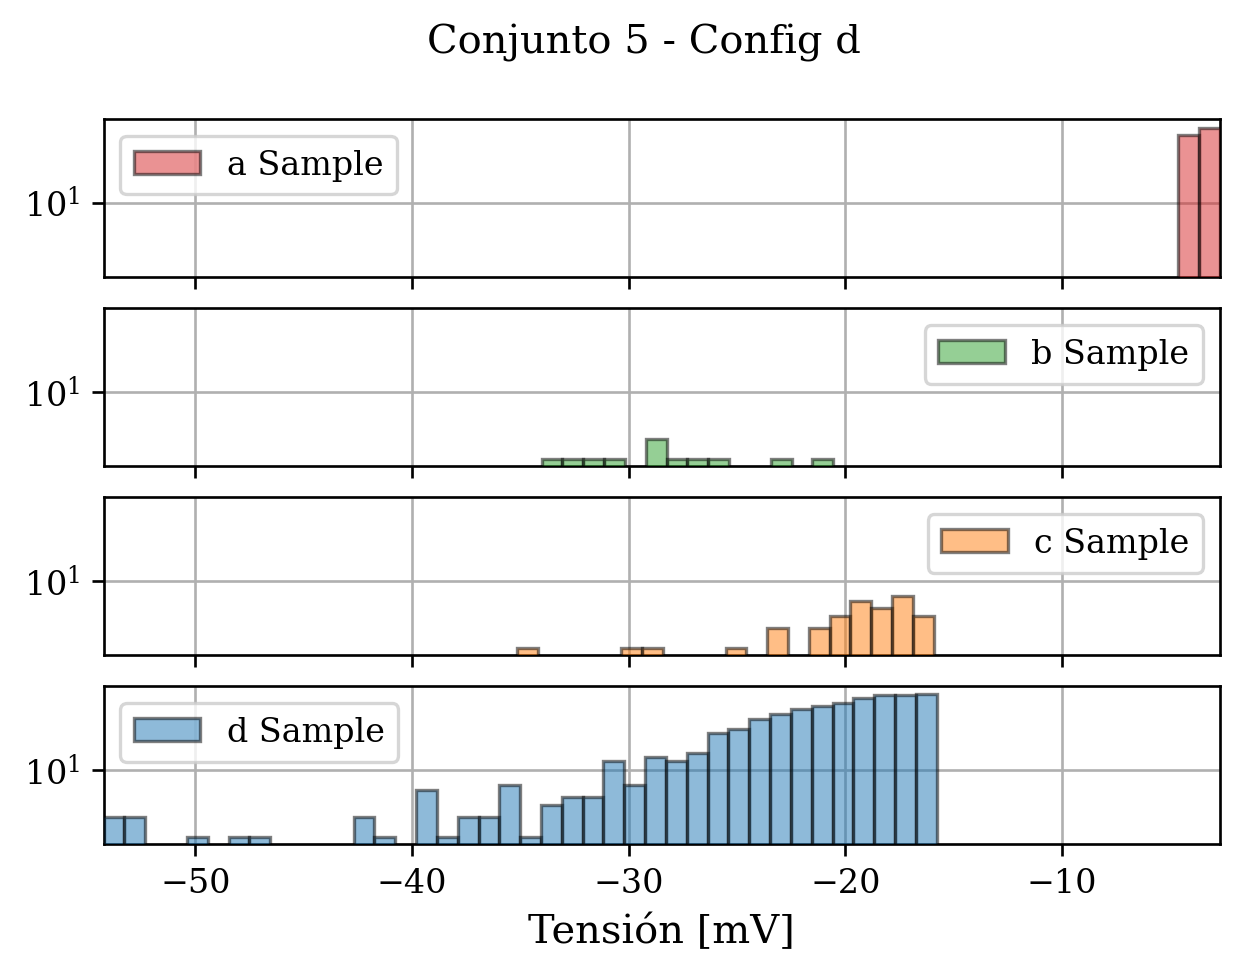

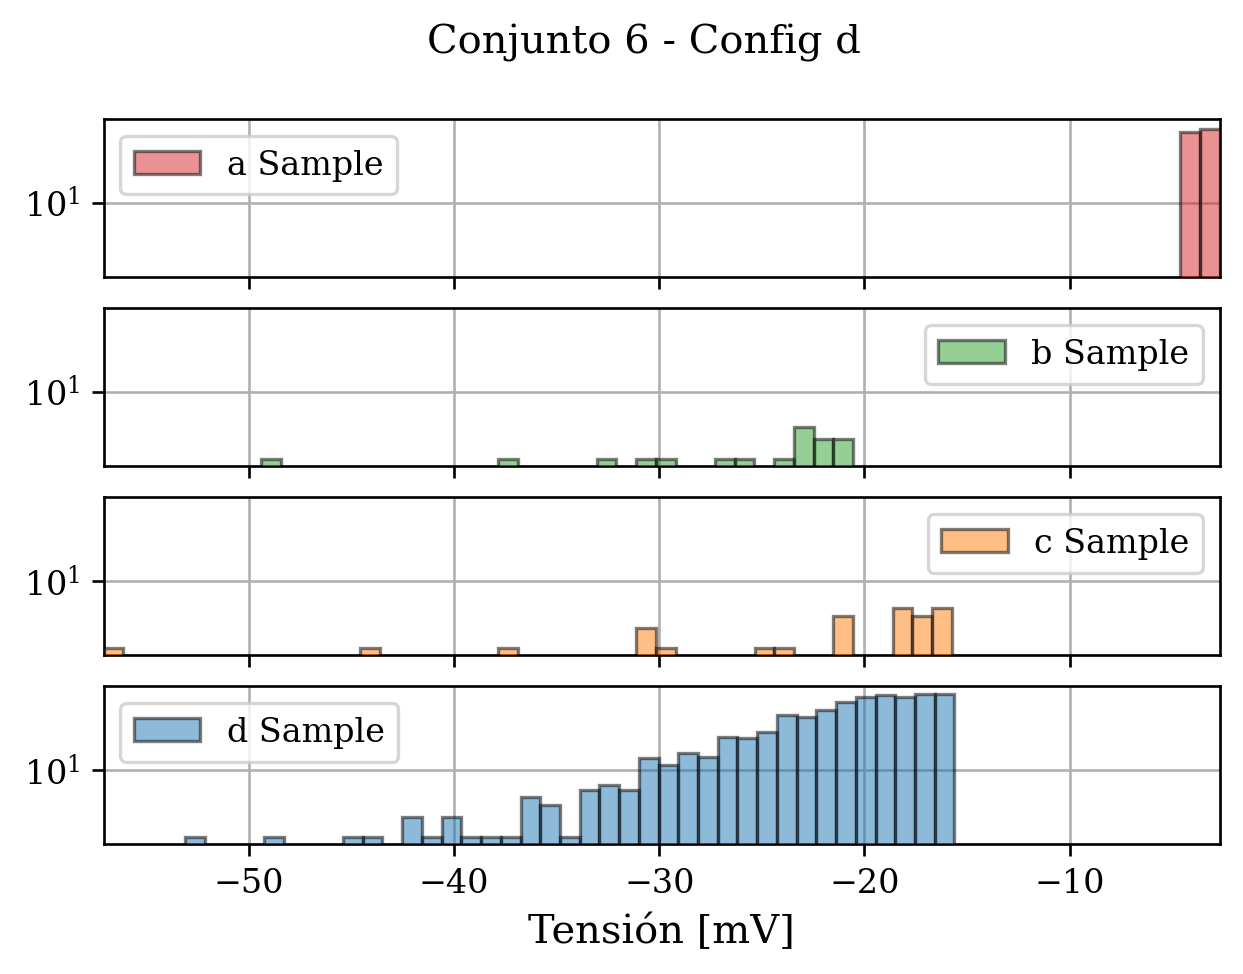

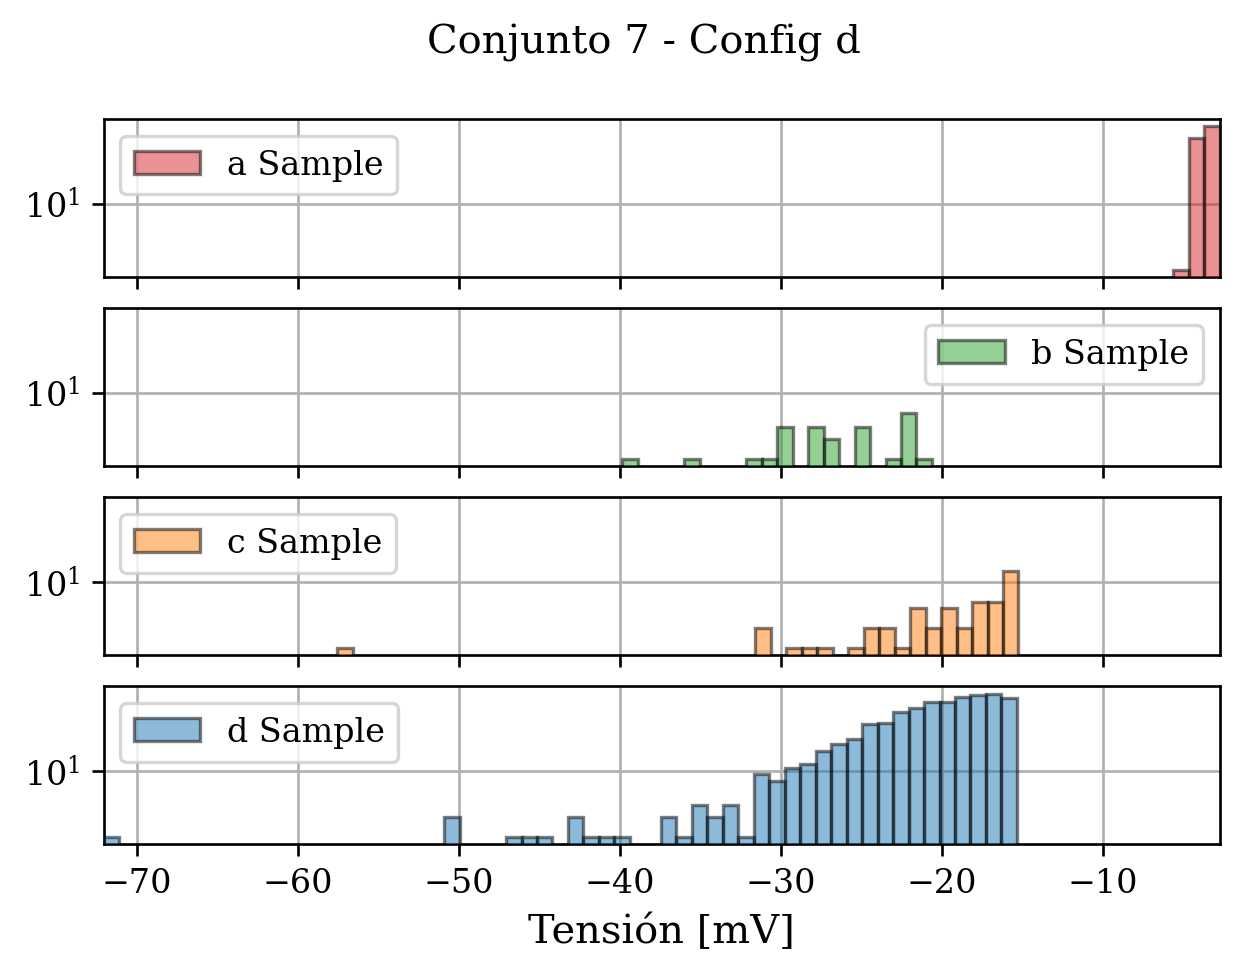

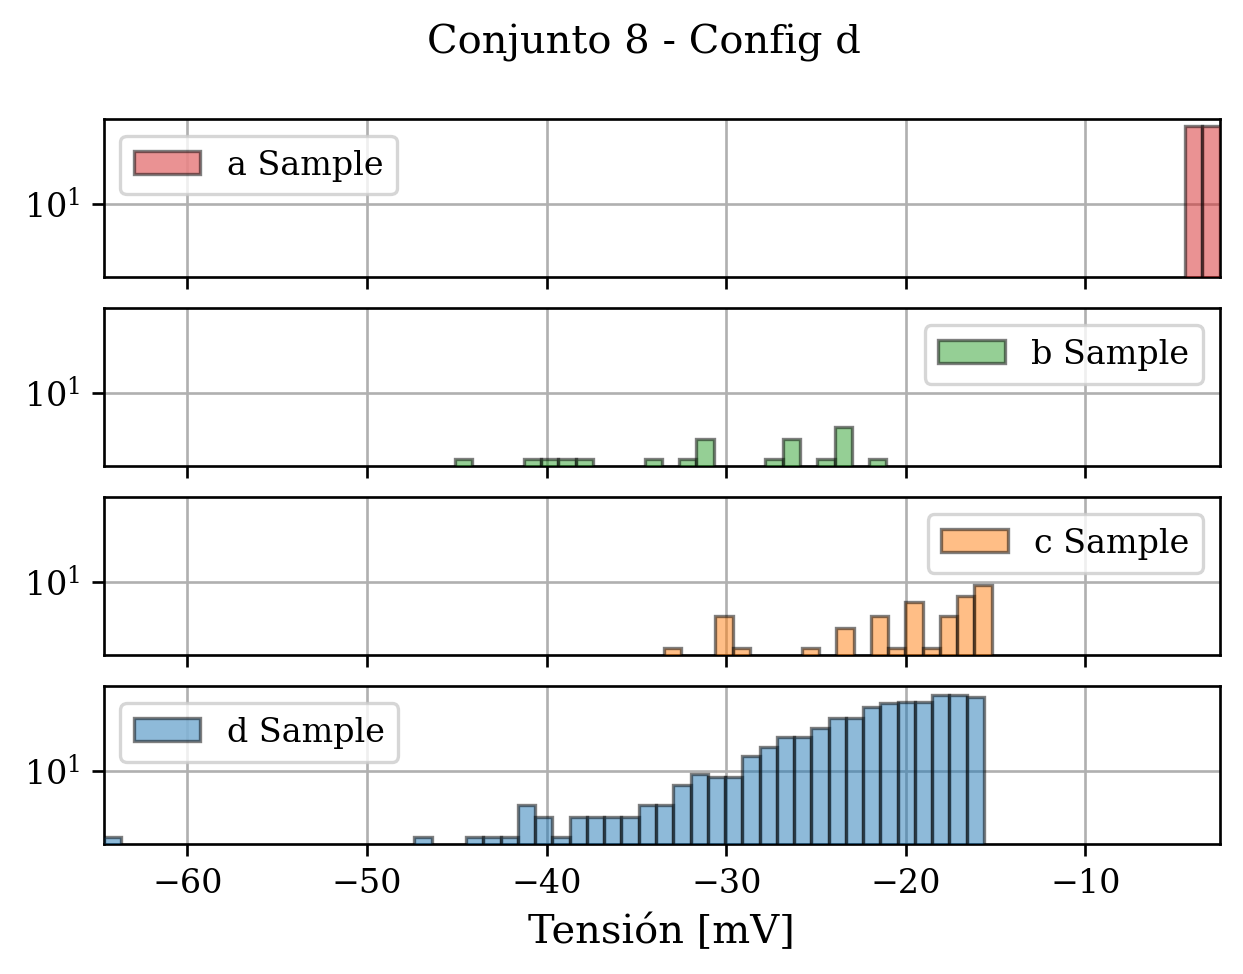

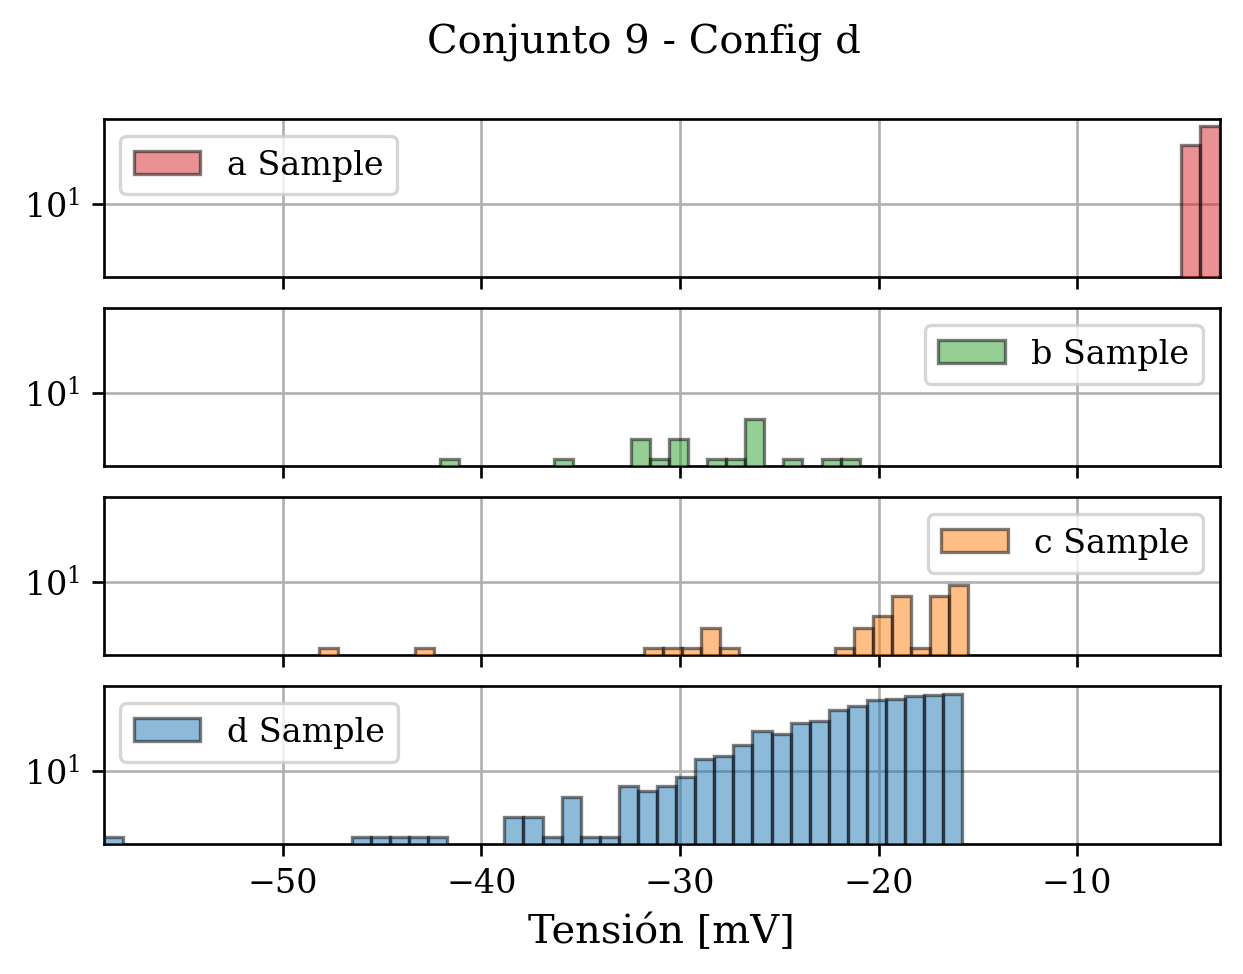

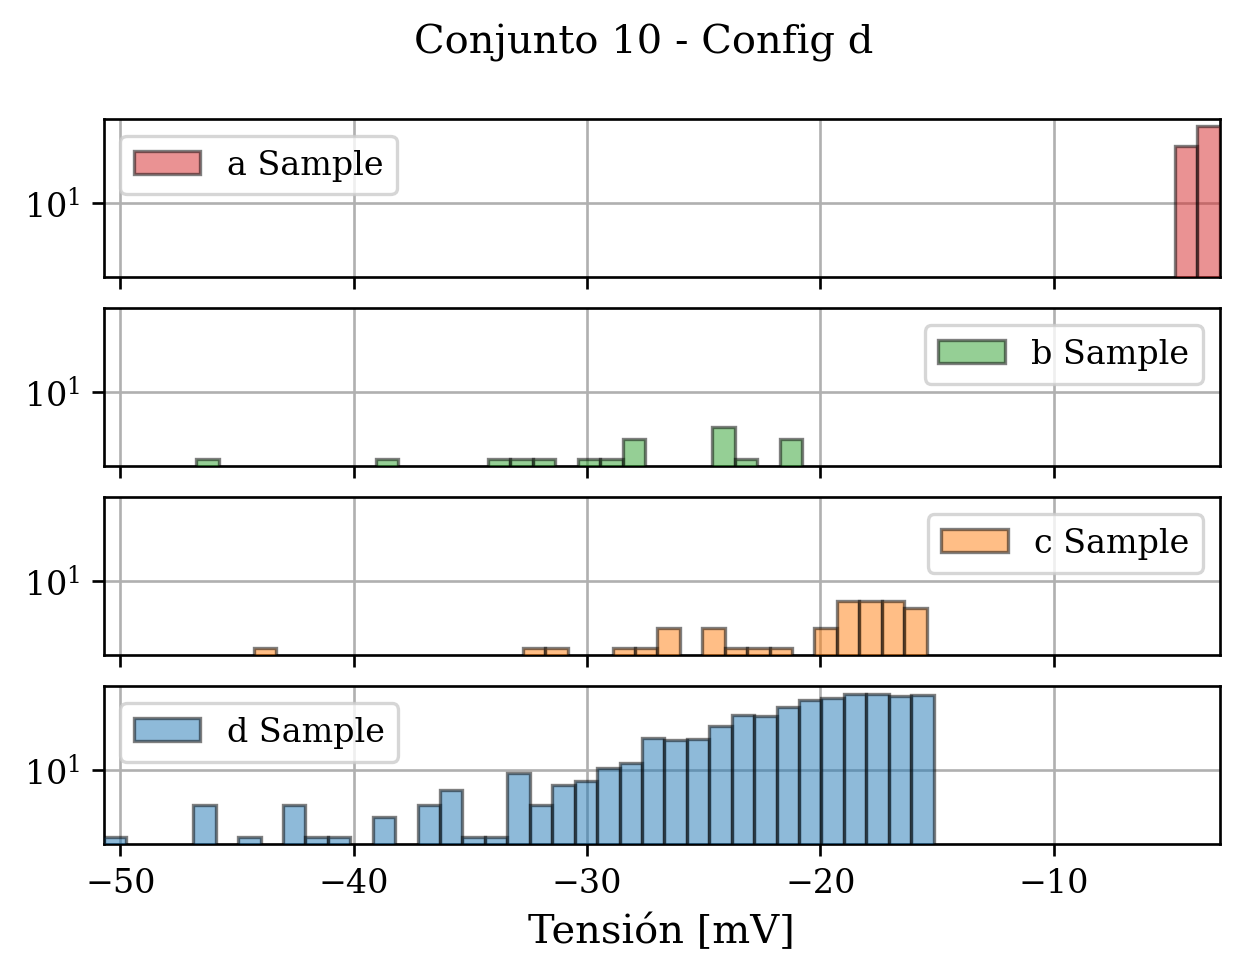

In [124]:
tension_dict_DAQ = dict()
height_dict_DAQ = dict()

angulo = 230
tension = 1050  # V
frec_muestreo = 250e3  # Hz
modo = 'sample'
max_val = 300e-3  # V
min_val = -300e-3  # V
split = 10

for i in range(10):
    fig, axs = plt.subplots(4, 1, sharex=True, sharey=True)
    fig.suptitle(f'Conjunto {i + 1} - Config {config}')
    color_id = 3
    for config, ax in zip(['a','b','c', 'd'], axs):    
        tiempo_, channel1_ = np.load(f"DAQ_10s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/{modo}_f{frec_muestreo*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  
        res = 1.05*(max_val - (min_val))/(2**16)  # V

        tiempo = np.array(np.split(tiempo_, split))[i]
        channel1 = np.array(np.split(channel1_, split))[i]

        if config == 'a':
            max = find_peaks(-channel1, height = 0.002,distance=100)[0]
        elif config == 'b':
            max = find_peaks(-channel1, height = 0.02,distance=100)[0]
        elif config == 'c':
            max = find_peaks(-channel1, height= 0.015, distance = 100)[0]
        elif config == 'd':
            max = find_peaks(-channel1, height= 0.015, distance = 100)[0]

        vals_unicos = np.unique(channel1[max])
        bin_edges = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, 100*res)  
        count, bin_edges = np.histogram(channel1[max], bin_edges, )
        #bin_center = np.arange(vals_unicos.min(), vals_unicos.max(), 100*res )  
        bin_center = bin_edges[:-1] + np.diff(bin_edges)/ 2
        bar_height = count  # /count.max()
        try:
            ax.bar(x=bin_center*1e3, height=bar_height, width=100*res*1e3,
                        color=f"C{color_id}", zorder=10, edgecolor="k",
                        alpha=0.5, label=config + " Sample")
        except ValueError:
            bin_center = np.arange(vals_unicos.min(), vals_unicos.max()+res/2, 100*res)  # V
            bar_height = count  # /count.max()
            ax.bar(x=bin_center[:-1]*1e3, height=bar_height, width=100*res*1e3,
                        color=f"C{color_id}", zorder=10, edgecolor="k",
                        alpha=0.5, label=config + " Sample")
        color_id -= 1
        height_dict_DAQ[f'{config}_{i}'] = bar_height
        tension_dict_DAQ[f'{config}_{i}'] = bin_center
        ax.set_yscale("log")
        ax.legend()
    ax.set_xlabel("Tensión [mV]")
    plt.show()


<ipython-input-149-2f25f4acf10b>:21: RuntimeWarning: invalid value encountered in long_scalars
  frac[i] = (positivos_d-positivos_c)/(positivos_d)


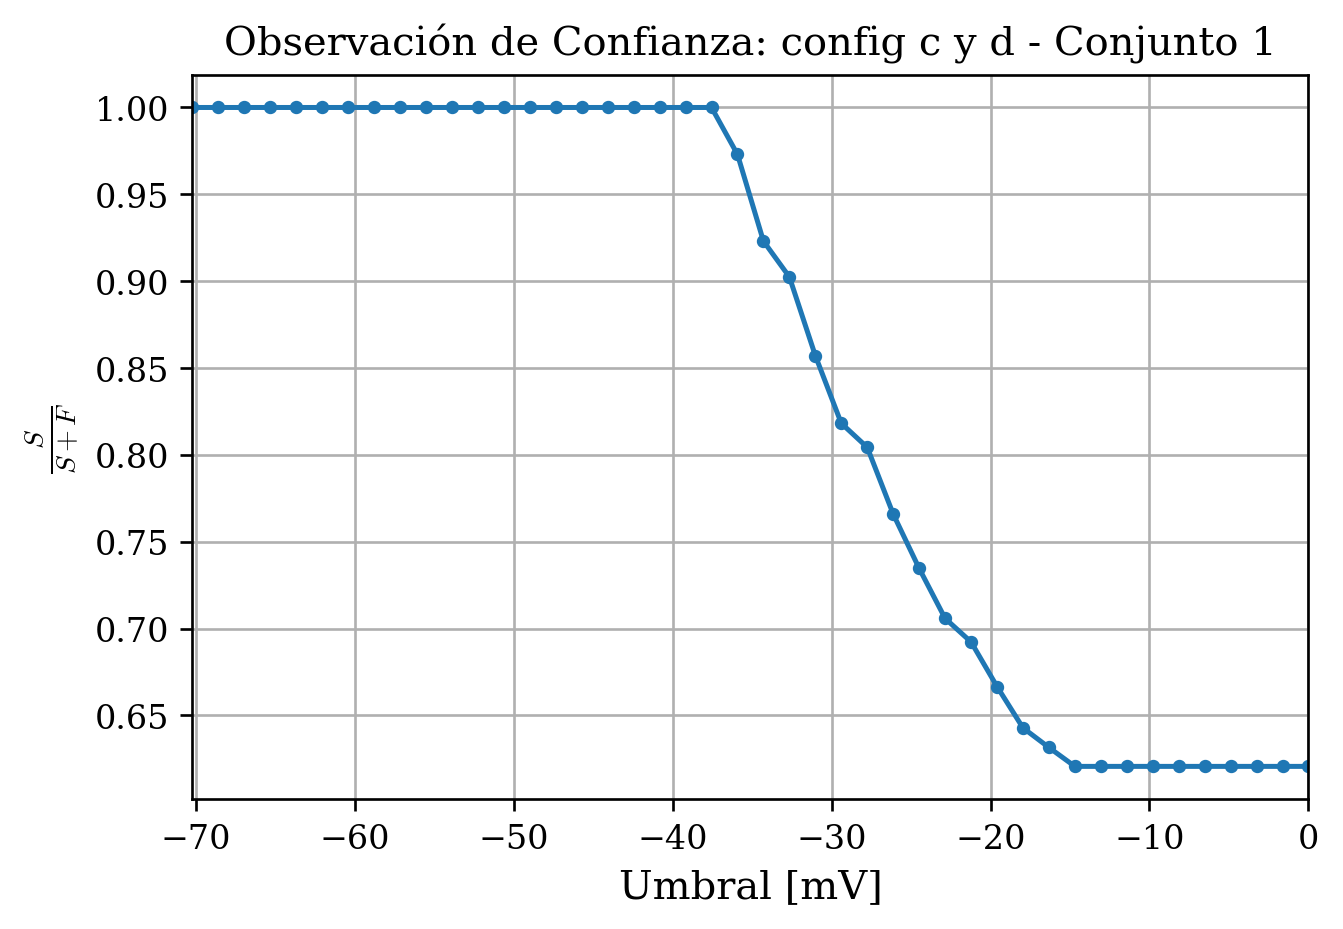

Posibles valores de Tension Umbral para conjunto 0: [-0.0442 -0.0432 -0.0423 -0.0413 -0.0404 -0.0394 -0.0384 -0.0375].
Y considerando el primer valor de tensión umbral se contaron 4 fotones.


<ipython-input-149-2f25f4acf10b>:21: RuntimeWarning: invalid value encountered in long_scalars
  frac[i] = (positivos_d-positivos_c)/(positivos_d)


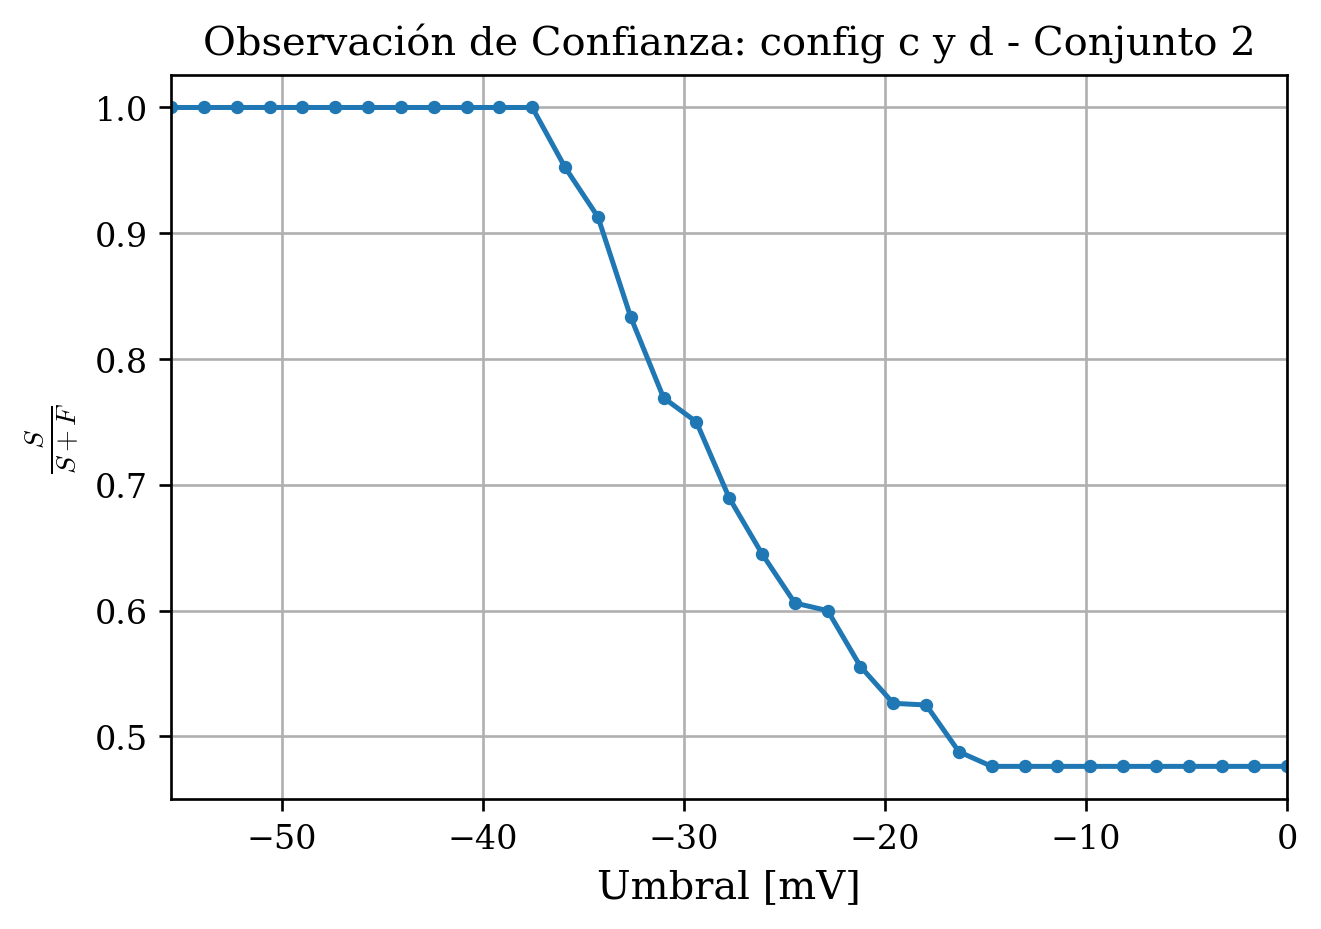

Posibles valores de Tension Umbral para conjunto 1: [-0.0296 -0.0287 -0.0277 -0.0268 -0.0258].
Y considerando el primer valor de tensión umbral se contaron 37 fotones.


<ipython-input-149-2f25f4acf10b>:21: RuntimeWarning: invalid value encountered in long_scalars
  frac[i] = (positivos_d-positivos_c)/(positivos_d)


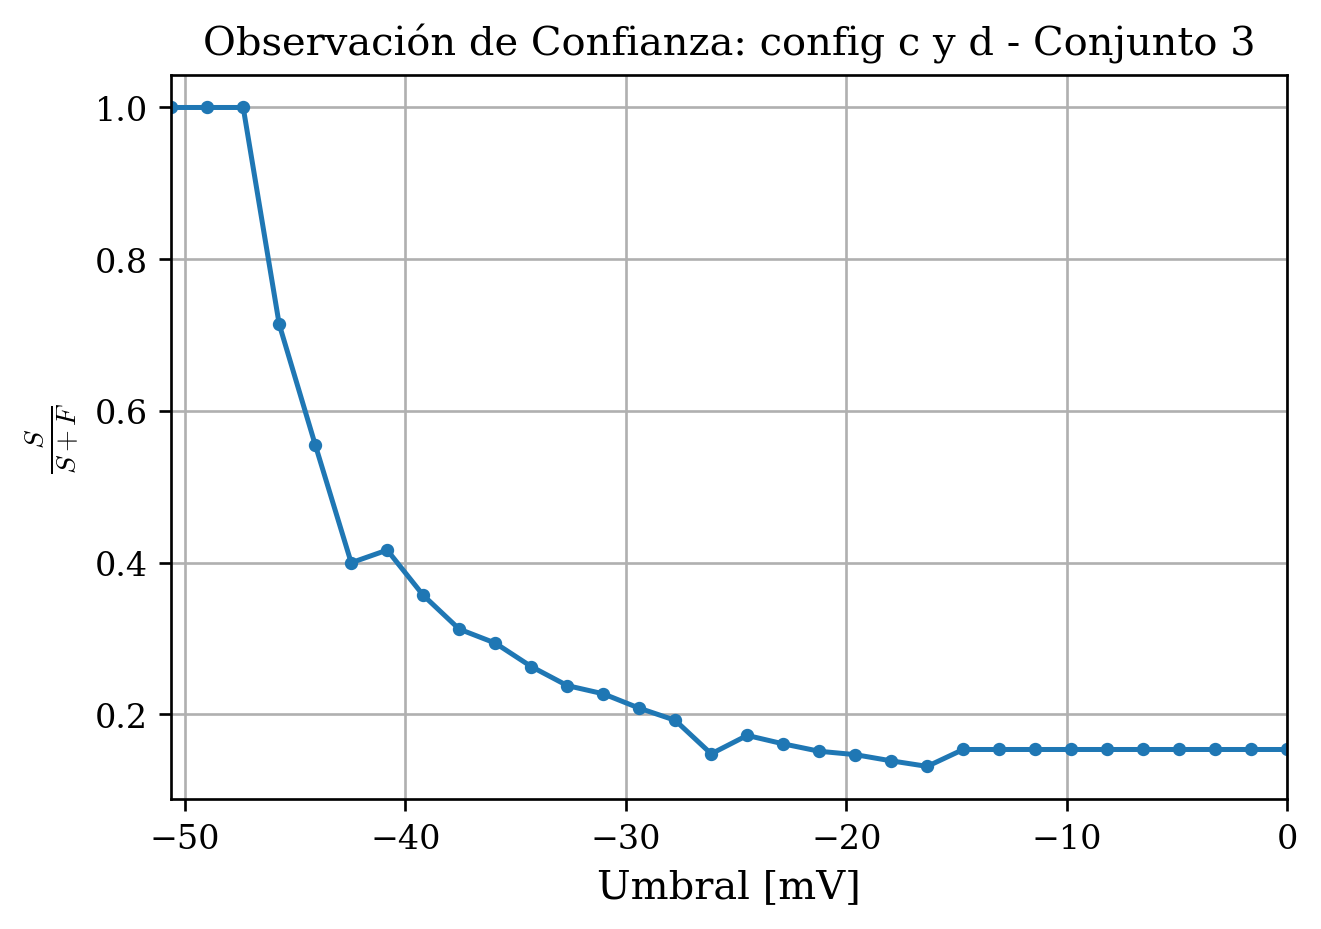

Posibles valores de Tension Umbral para conjunto 2: [-0.0318].
Y considerando el primer valor de tensión umbral se contaron 22 fotones.


<ipython-input-149-2f25f4acf10b>:21: RuntimeWarning: invalid value encountered in long_scalars
  frac[i] = (positivos_d-positivos_c)/(positivos_d)


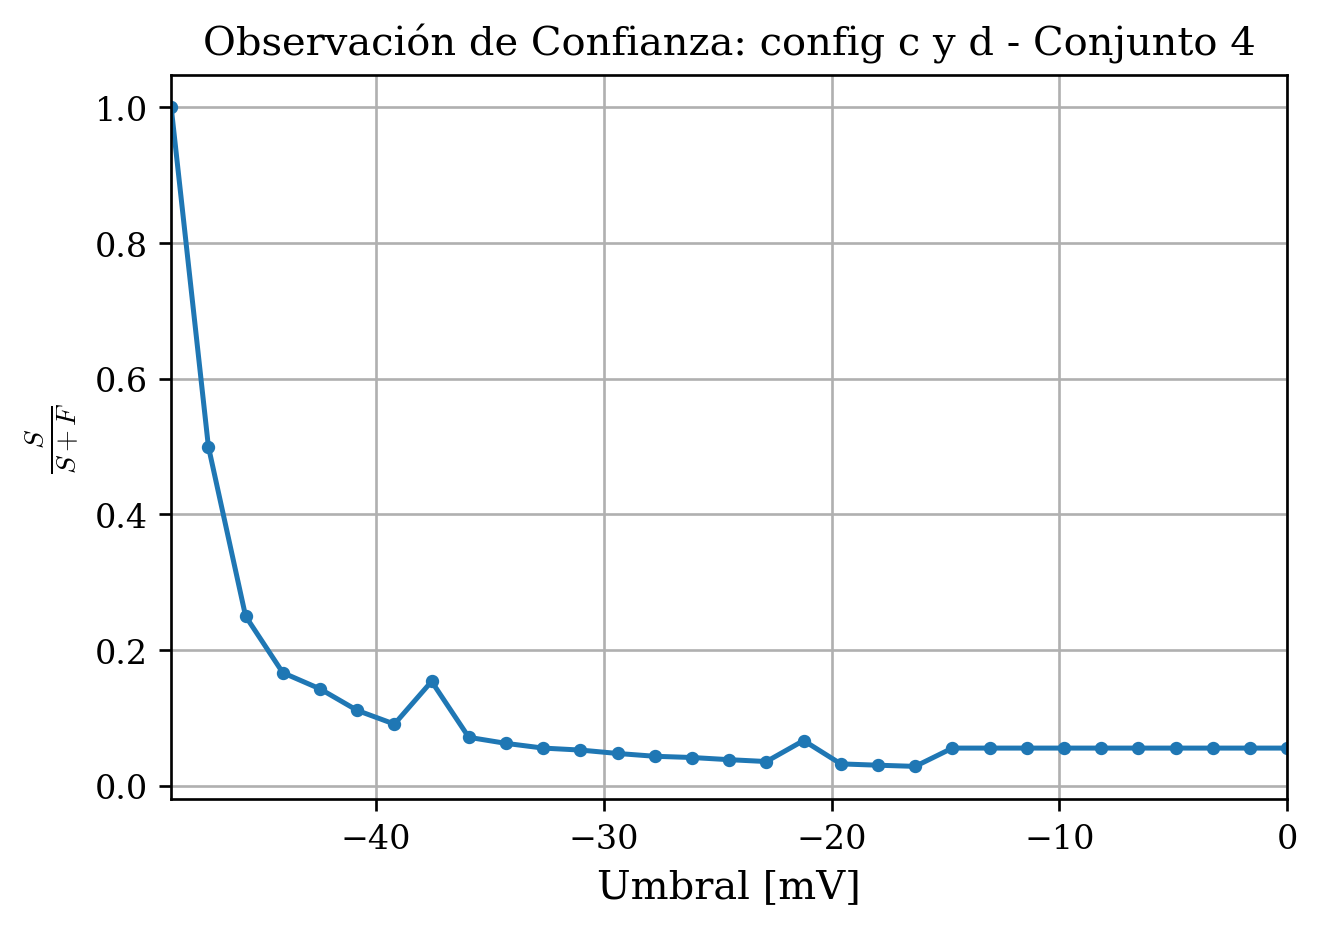

Posibles valores de Tension Umbral para conjunto 3: [].
Y considerando el primer valor de tensión umbral se contaron 0 fotones.


<ipython-input-149-2f25f4acf10b>:21: RuntimeWarning: invalid value encountered in long_scalars
  frac[i] = (positivos_d-positivos_c)/(positivos_d)


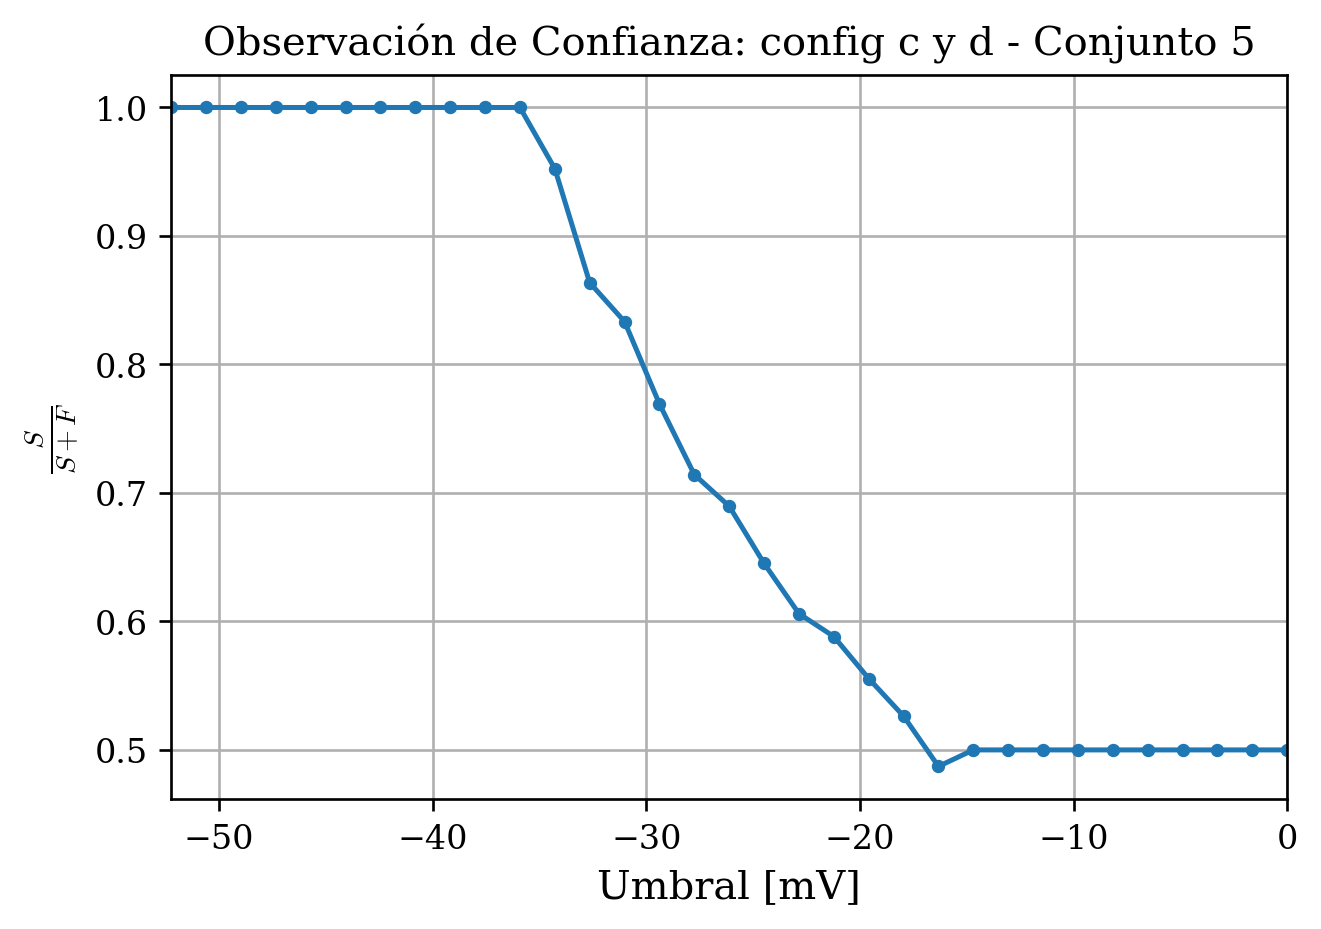

Posibles valores de Tension Umbral para conjunto 4: [-0.0268 -0.0259 -0.0249 -0.0239 -0.023 ].
Y considerando el primer valor de tensión umbral se contaron 83 fotones.


<ipython-input-149-2f25f4acf10b>:21: RuntimeWarning: invalid value encountered in long_scalars
  frac[i] = (positivos_d-positivos_c)/(positivos_d)
<ipython-input-149-2f25f4acf10b>:21: RuntimeWarning: divide by zero encountered in long_scalars
  frac[i] = (positivos_d-positivos_c)/(positivos_d)


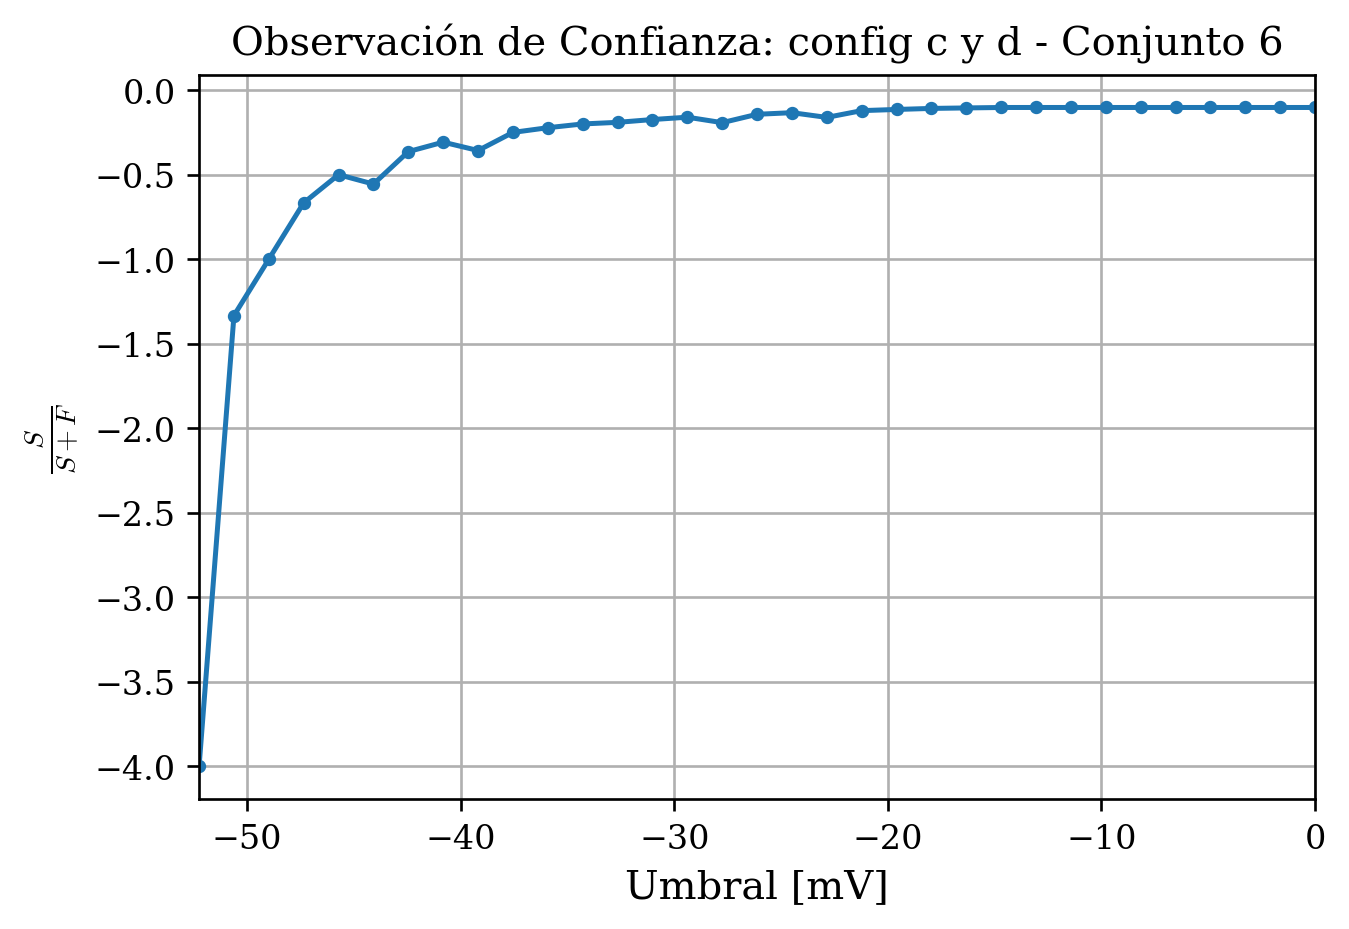

Posibles valores de Tension Umbral para conjunto 5: [].
Y considerando el primer valor de tensión umbral se contaron 0 fotones.


<ipython-input-149-2f25f4acf10b>:21: RuntimeWarning: invalid value encountered in long_scalars
  frac[i] = (positivos_d-positivos_c)/(positivos_d)


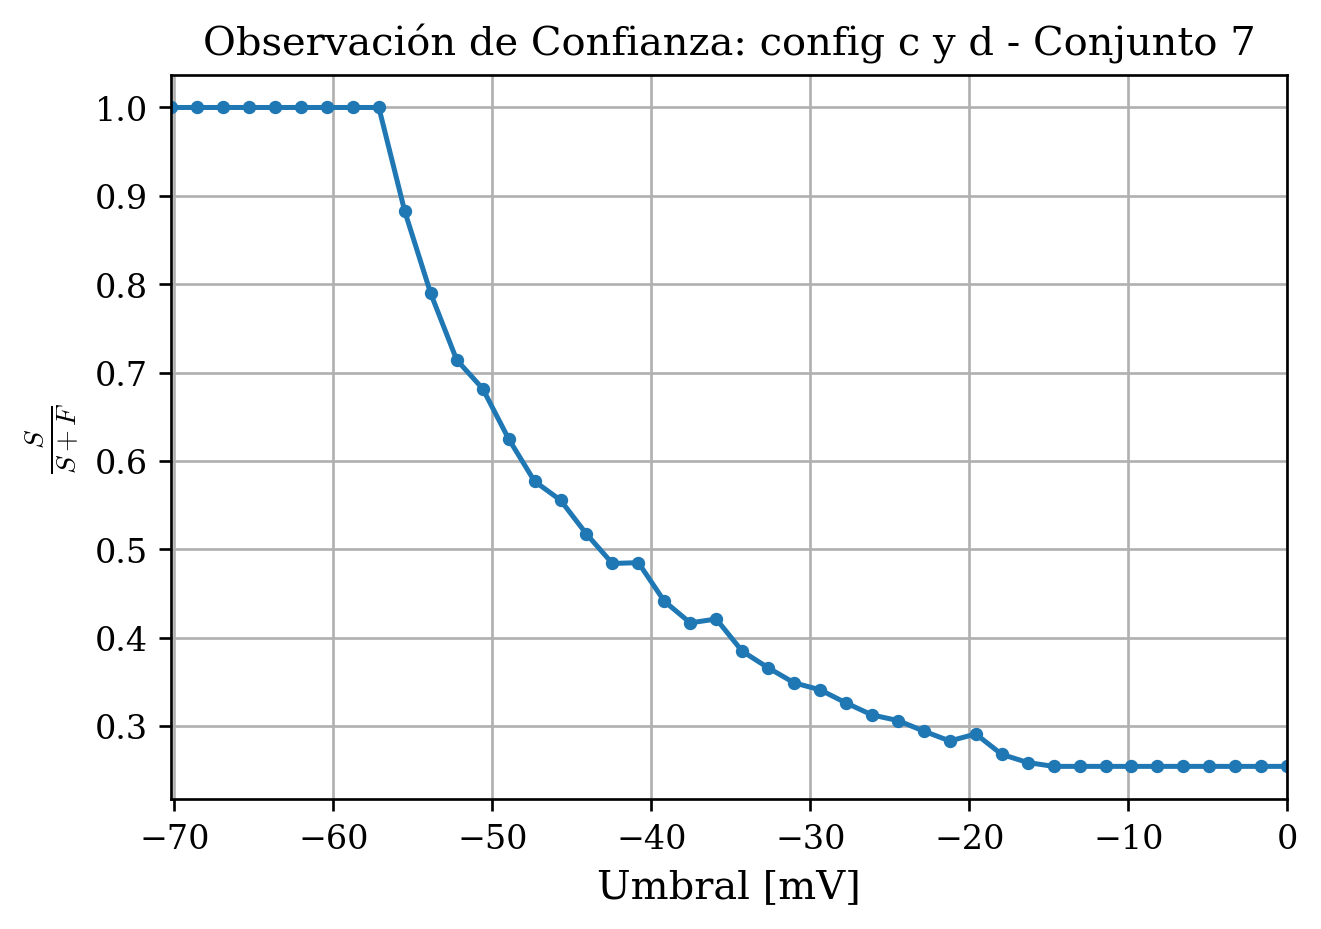

Posibles valores de Tension Umbral para conjunto 6: [-0.0572 -0.0562 -0.0552].
Y considerando el primer valor de tensión umbral se contaron 0 fotones.


<ipython-input-149-2f25f4acf10b>:21: RuntimeWarning: invalid value encountered in long_scalars
  frac[i] = (positivos_d-positivos_c)/(positivos_d)


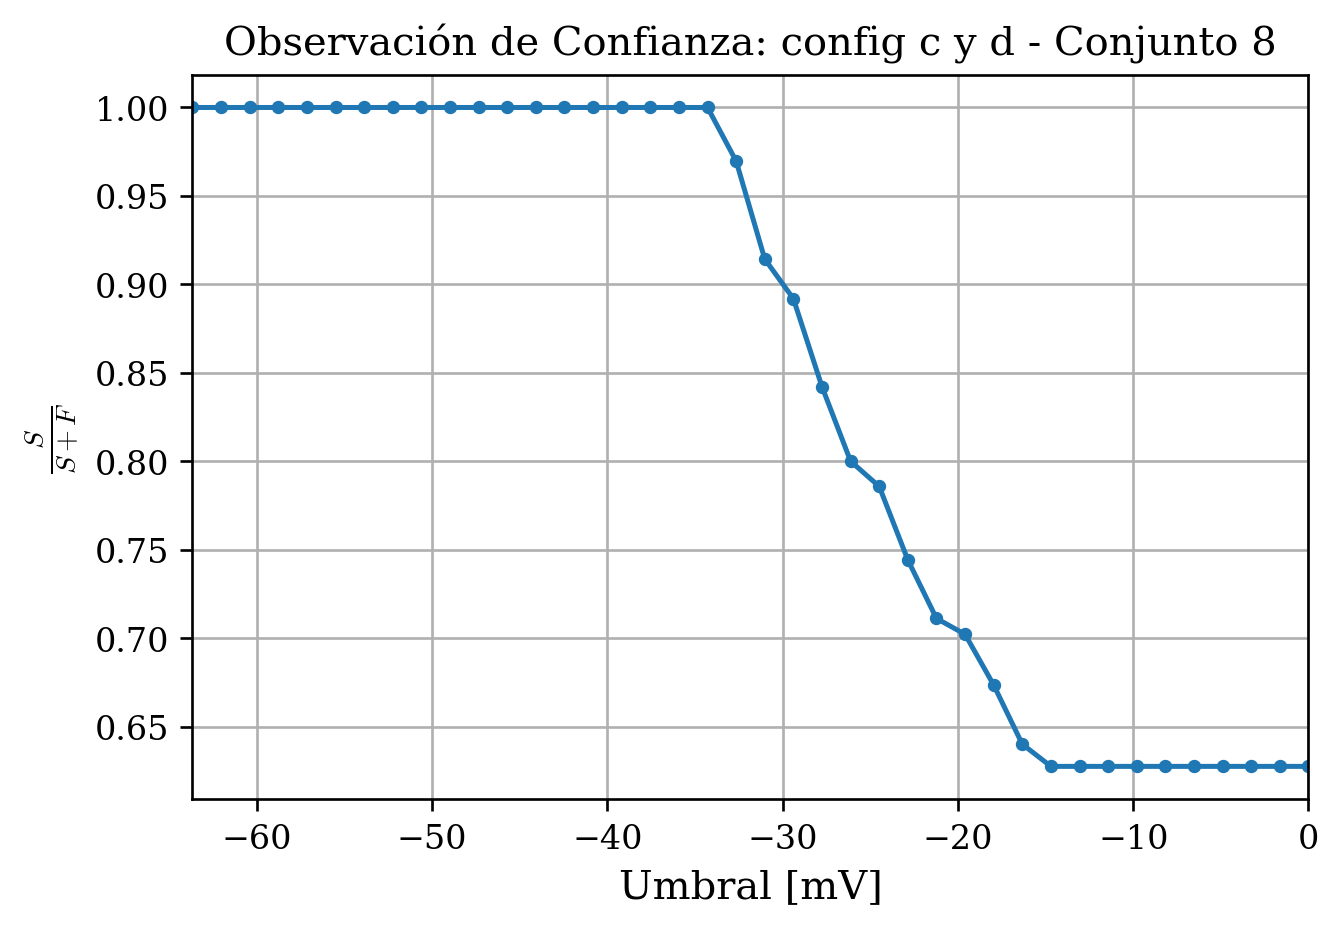

Posibles valores de Tension Umbral para conjunto 7: [-0.0353 -0.0344 -0.0334 -0.0325 -0.0315 -0.0305 -0.0296 -0.0286].
Y considerando el primer valor de tensión umbral se contaron 15 fotones.


<ipython-input-149-2f25f4acf10b>:21: RuntimeWarning: invalid value encountered in long_scalars
  frac[i] = (positivos_d-positivos_c)/(positivos_d)


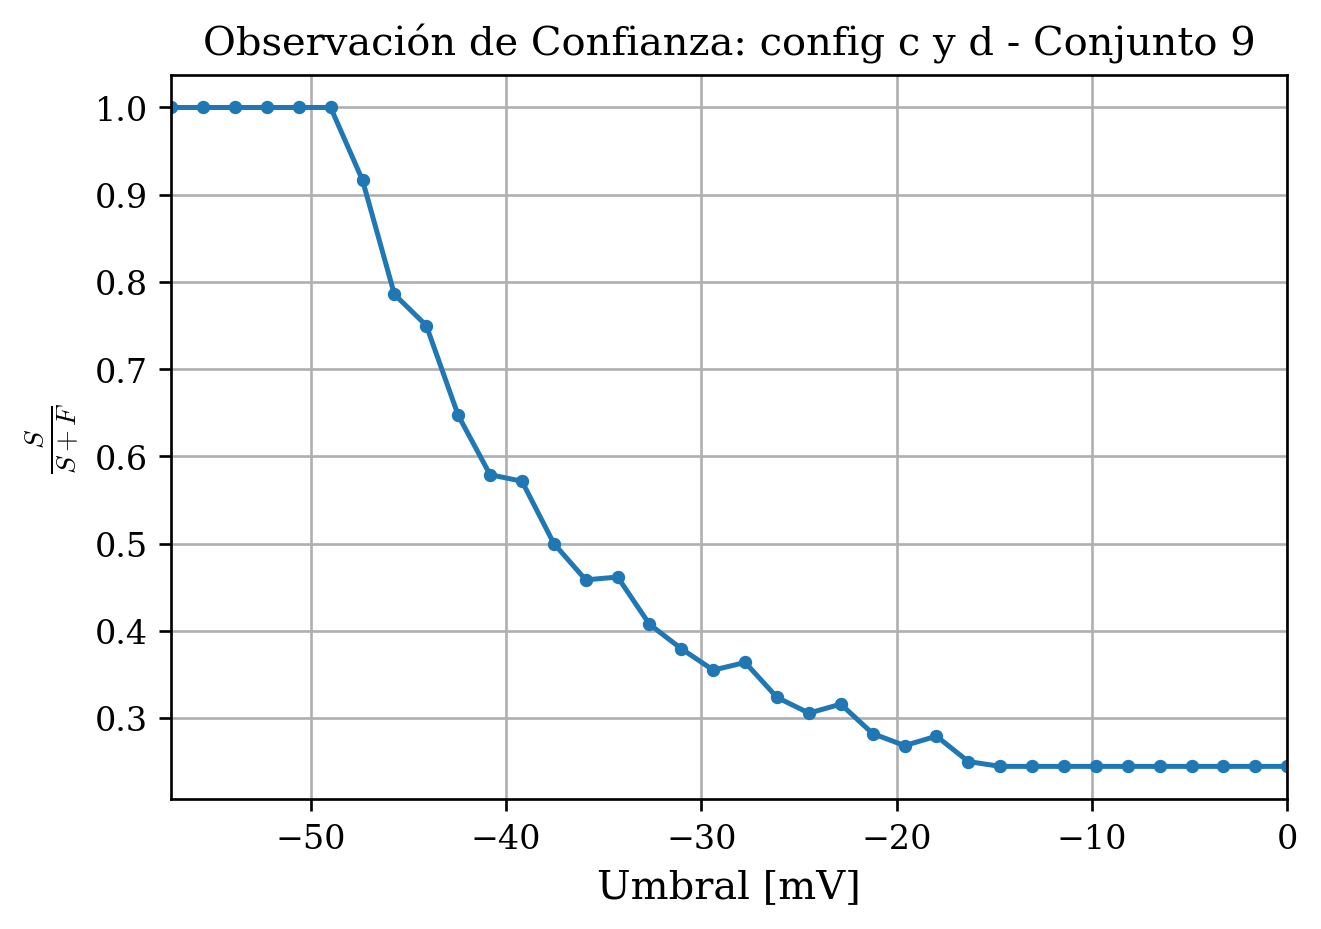

Posibles valores de Tension Umbral para conjunto 8: [-0.0393 -0.0384 -0.0374].
Y considerando el primer valor de tensión umbral se contaron 5 fotones.


<ipython-input-149-2f25f4acf10b>:21: RuntimeWarning: invalid value encountered in long_scalars
  frac[i] = (positivos_d-positivos_c)/(positivos_d)


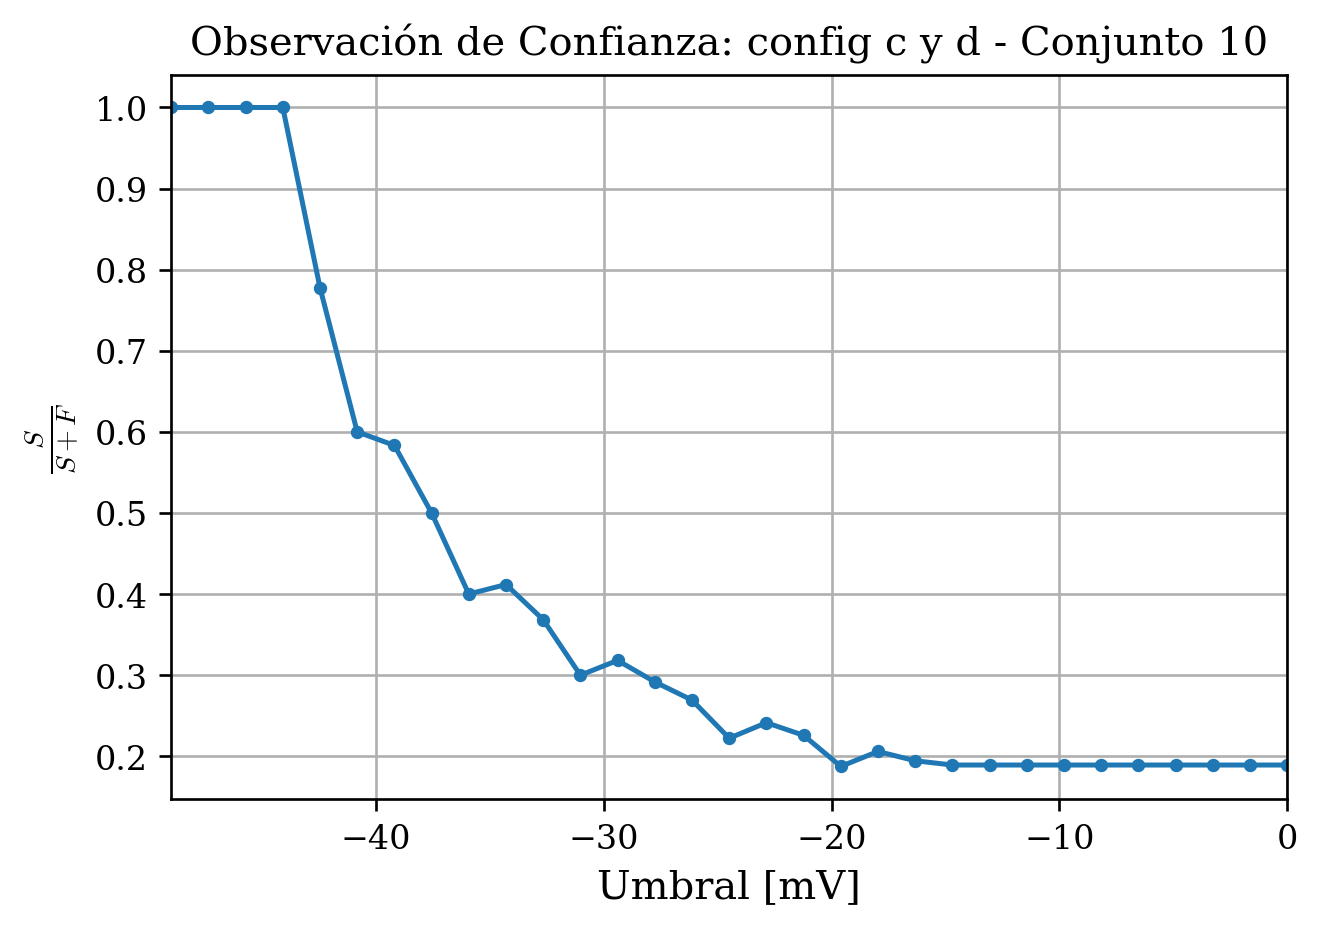

Posibles valores de Tension Umbral para conjunto 9: [-0.0281].
Y considerando el primer valor de tensión umbral se contaron 45 fotones.


In [149]:
#Planteo Tensión Umbral
#Con la fracción de 'confianza' calculo el número de fotones medidos

umbrales = np.linspace(-80e-3, 0, )
n = np.zeros_like(range(split))

#Considero todos los subconjuntos del array original y veo de calcular en cada caso una tensión umbral
#Se que igualmente el grupo anterior tomo una generica para todos los arrays
#Esto igualmente lo hago para ver si es coherente hacer eso si queremos considerar un == % de confianza
#Algo a revisar tambien es que en un par de casos el método para considerar frac se rome (es raro porque los graficos anteriores no van en coherencia con este error, por lo menos a simple viste)
#El mayor problema viene del conjunto 6

for j in range(split):

    i_ = [] #posición de tensión umbral
    vumb = [] #Valores de Tension umbral
    frac = np.zeros_like(umbrales)

    for i, umbral in enumerate(umbrales):  # V
        positivos_d = sum(tension_dict_DAQ[f"d_{j}"] <  umbral)
        positivos_c = sum(tension_dict_DAQ[f"c_{j}"] <  umbral)
        frac[i] = (positivos_d-positivos_c)/(positivos_d)
        #Criterio para ver tensiones umbrales (elijo los porcentajes)
        if 0.7<frac[i] <0.96:
            vumb.append(tension_dict_DAQ[f"d_{j}"][i])
            i_.append(i)

    plt.title(f'Observación de Confianza: config c y d - Conjunto {j + 1}')
    plt.plot(umbrales*1e3, frac, '.-')
    plt.xlabel("Umbral [mV]")
    plt.ylabel(r"$\frac{S}{S+F}$")
    plt.show()

    #Calculo el Número de fotones observados considerando la suma de alturas medidas por la fracción de confianza que tenga
    if i_ != []:
        n[j] = sum(height_dict_DAQ[f"d_{j}"][0:i_[0]])*frac[i_[0]]

    print(f'Posibles valores de Tension Umbral para conjunto {j}: {np.round(vumb, 4)}.\nY considerando el primer valor de tensión umbral se contaron {n[j]} fotones.')


### Ajustes

In [150]:
from math import factorial

def poisson(n, mean_n):
    n = np.array(n)
    mean_n = np.array(mean_n)
    pn = np.array(((mean_n)**n/(factorial(n)))*np.exp(-mean_n))
    return pn

def bose_einstein(n, mean_n):
    pn = (mean_n**n)/(1 + mean_n)**(1 + n)
    return pn

In [153]:
#Hago el mismo planteo que lo anterior pero tomando 100 subconjuntos y sin graficar nada
#Después veo de ver la distribución de la cantidad de fotones medidos

tension_dict_DAQ = dict()
height_dict_DAQ = dict()

angulo = 230
tension = 1050  # V
frec_muestreo = 250e3  # Hz
modo = 'sample'
max_val = 300e-3  # V
min_val = -300e-3  # V
split = 100

umbrales = np.linspace(-80e-3, 0, )
n = np.zeros_like(range(split))

for i in range(split):
    for config, ax in zip(['a','b','c', 'd'], axs):    
        tiempo_, channel1_ = np.load(f"DAQ_10s_{max_val*1e3:.0f}_{min_val*1e3:.0f}/{modo}_f{frec_muestreo*1e-3:.0f}k_a{angulo}_t{tension}_{config}.npy")  
        res = 1.05*(max_val - (min_val))/(2**16)  # V

        tiempo = np.array(np.split(tiempo_, split))[i]
        channel1 = np.array(np.split(channel1_, split))[i]

        if config == 'a':
            max = find_peaks(-channel1, height = 0.002,distance=100)[0]
        elif config == 'b':
            max = find_peaks(-channel1, height = 0.02,distance=100)[0]
        elif config == 'c':
            max = find_peaks(-channel1, height= 0.015, distance = 100)[0]
        elif config == 'd':
            max = find_peaks(-channel1, height= 0.015, distance = 100)[0]

        vals_unicos = np.unique(channel1[max])
        bin_edges = np.arange(vals_unicos.min() - res/2, vals_unicos.max()+res/2, 100*res)  
        count, bin_edges = np.histogram(channel1[max], bin_edges, )
        bin_center = bin_edges[:-1] + np.diff(bin_edges)/ 2
        bar_height = count  # /count.max()
        height_dict_DAQ[f'{config}_{i}'] = bar_height
        tension_dict_DAQ[f'{config}_{i}'] = bin_center

    i_ = [] #posición de tensión umbral
    vumb = [] #valores de Tension umbral
    frac = np.zeros_like(umbrales)

    for j, umbral in enumerate(umbrales):  # V
        positivos_d = sum(tension_dict_DAQ[f"d_{i}"] <  umbral)
        positivos_c = sum(tension_dict_DAQ[f"c_{i}"] <  umbral)
        frac[j] = (positivos_d-positivos_c)/(positivos_d)
        #Criterio para ver tensiones umbrales (elijo los porcentajes)
        if 0.8<frac[j] <0.96:
            vumb.append(tension_dict_DAQ[f"d_{i}"][j])
            i_.append(j)

    #Calculo el Número de fotones observados considerando la suma de alturas medidas por la fracción de confianza que tenga
    if i_ != []:
        n[i] = sum(height_dict_DAQ[f"d_{i}"][0:i_[0]])*frac[i_[0]]

    print(f'Posibles valores de Tension Umbral para conjunto {i}: {np.round(vumb, 4)}.\nY considerando el primer valor de tensión umbral se contaron {n[i]} fotones.')

#Calculo la valores unicos de fotones que se contaron 
# y el número de veces que se obtuvrieron esos valores
n_unicos, n_cant = np.unique(n, return_counts=True)
pn = n_cant/sum(n_cant)

<ipython-input-153-df0ed964d76a>:50: RuntimeWarning: invalid value encountered in long_scalars
  frac[j] = (positivos_d-positivos_c)/(positivos_d)


Posibles valores de Tension Umbral para conjunto 0: [].
Y considerando el primer valor de tensión umbral se contaron 0 fotones.
Posibles valores de Tension Umbral para conjunto 1: [].
Y considerando el primer valor de tensión umbral se contaron 0 fotones.


IndexError: index 38 is out of bounds for axis 0 with size 24

In [79]:
popt, pcov = curve_fit(poisson, n, pn)
mean_n = popt
n_linspace = np.linspace(min(n), max(n), 1000)

plt.figure(figsize=(8, 5.5))
plt.plot(tension_dict_DAQ["c"], height_dict_DAQ["c"], 'o--k', mfc='red', mec='black', mew=1, label= 'Data')
plt.plot(n_linspace, poisson(n_linspace, mean_n),'--', label=f'fit')
plt.title(f'Ajuste Gaussiano. <n> = {mean_n}. n = {n}')
plt.grid()
plt.xlabel('Tensión [V]')
plt.ylabel('Diferencia longitud de onda [nm]')
plt.legend()
plt.show()

TypeError: only integer scalar arrays can be converted to a scalar index